In [1]:
import os
import sys
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

repo_path = os.path.dirname(os.path.abspath(""))

CHECKOUT_PATH = repo_path
DATA_PATH = os.path.join(repo_path, "data")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

# Virtual screening performance (Table 1)

### Calculate VS performance

In [2]:
from utils.analysis_utils import get_label_dict, vs_performance
diffdock_L_docking_dir = os.path.join(DATA_PATH, "docking_poses", "DiffDock_L")
vina_docking_dir = os.path.join(DATA_PATH, "docking_poses", "Vina")
label_dir = os.path.join(DATA_PATH, "dudez")
targets = os.listdir(label_dir)

def check_vs_performance(target):
    """
    Check virtual screening performance of different docking settings on a target.
    """
    
    label_dict = get_label_dict(label_dir, target)

    diffdock_L_input_file_gnina = os.path.join(diffdock_L_docking_dir, target.upper(), "score", f"poses_minimized_gnina.sdf")
    diffdock_L_gnina_auc, [diffdock_L_gnina_ef1, diffdock_L_gnina_ef5], diffdock_L_gnina_bedroc = vs_performance(diffdock_L_input_file_gnina, "diffdock_L", "gnina", label_dict)

    diffdock_L_input_file_vina = os.path.join(diffdock_L_docking_dir, target.upper(), "score", f"poses_minimized_vina.sdf")
    diffdock_L_vina_auc, [diffdock_L_vina_ef1, diffdock_L_vina_ef5], diffdock_L_vina_bedroc = vs_performance(diffdock_L_input_file_vina, "diffdock_L", "vina", label_dict)

    vina_input_file_vina = os.path.join(vina_docking_dir, target.lower(), f"{target.lower()}_docked.sdf")
    vina_vina_auc, [vina_vina_ef1, vina_vina_ef5], vina_vina_bedroc = vs_performance(vina_input_file_vina, "vina", "vina", label_dict)

    vina_input_file_gnina = os.path.join(vina_docking_dir, target.lower(), "score", f"{target.lower()}_gnina.sdf")
    vina_gnina_auc, [vina_gnina_ef1, vina_gnina_ef5], vina_gnina_bedroc = vs_performance(vina_input_file_gnina, "vina", "gnina", label_dict)

    auc_dict = {'diffdock_L+gnina': diffdock_L_gnina_auc, 'diffdock_L+vina': diffdock_L_vina_auc, 'vina+vina': vina_vina_auc, 'vina+gnina': vina_gnina_auc}
    ef1_dict = {'diffdock_L+gnina': diffdock_L_gnina_ef1, 'diffdock_L+vina': diffdock_L_vina_ef1, 'vina+vina': vina_vina_ef1, 'vina+gnina': vina_gnina_ef1}
    ef5_dict = {'diffdock_L+gnina': diffdock_L_gnina_ef5, 'diffdock_L+vina': diffdock_L_vina_ef5, 'vina+vina': vina_vina_ef5, 'vina+gnina': vina_gnina_ef5}
    bedroc_dict = {'diffdock_L+gnina': diffdock_L_gnina_bedroc, 'diffdock_L+vina': diffdock_L_vina_bedroc, 'vina+vina': vina_vina_bedroc, 'vina+gnina': vina_gnina_bedroc}

    return auc_dict, ef1_dict, ef5_dict, bedroc_dict

target_auc = {}
target_ef1 = {}
target_ef5 = {}
target_bedroc = {}

with Pool(processes=len(targets)) as pool:
    it = pool.map(check_vs_performance, targets)
for i, result in enumerate(it):
    target = targets[i]
    target_auc[target], target_ef1[target], target_ef5[target], target_bedroc[target] = result

Read poses_minimized_gnina.sdf: 1197 molecules.
Read poses_minimized_gnina.sdf: 1321 molecules.
Read poses_minimized_gnina.sdf: 1884 molecules.
Read poses_minimized_gnina.sdf: 1937 molecules.
Read poses_minimized_gnina.sdf: 1936 molecules.
Read poses_minimized_gnina.sdf: 2185 molecules.
Read poses_minimized_gnina.sdf: 2193 molecules.
Read poses_minimized_gnina.sdf: 2269 molecules.
Read poses_minimized_gnina.sdf: 2192 molecules.
Read poses_minimized_gnina.sdf: 2142 molecules.
Read poses_minimized_gnina.sdf: 2191 molecules.
Read poses_minimized_gnina.sdf: 2244 molecules.
Read poses_minimized_gnina.sdf: 2295 molecules.
Read poses_minimized_gnina.sdf: 2346 molecules.
Read poses_minimized_gnina.sdf: 2244 molecules.
Read poses_minimized_vina.sdf: 1197 molecules.
Read poses_minimized_gnina.sdf: 2447 molecules.
Read poses_minimized_gnina.sdf: 2646 molecules.
Read poses_minimized_gnina.sdf: 2753 molecules.
Read poses_minimized_vina.sdf: 1321 molecules.
Read poses_minimized_gnina.sdf: 2702 molec

In [ ]:
auc_df = pd.DataFrame.from_dict(target_auc, orient='index')
ef1_df = pd.DataFrame.from_dict(target_ef1, orient='index')
ef5_df = pd.DataFrame.from_dict(target_ef5, orient='index')
bedroc_df = pd.DataFrame.from_dict(target_bedroc, orient='index')

outdir = os.path.join(DATA_PATH, "analysis")
os.makedirs(outdir, exist_ok=True)

auc_df.to_csv(os.path.join(outdir, "dudez_auc.csv"))
ef1_df.to_csv(os.path.join(outdir, "dudez_ef1.csv"))
ef5_df.to_csv(os.path.join(outdir, "dudez_ef5.csv"))
bedroc_df.to_csv(os.path.join(outdir, "dudez_bedroc.csv"))

### Plotting

In [2]:
# read data from csv (For Figure 2 & 3)
outdir = os.path.join(DATA_PATH, "analysis")
auc_df = pd.read_csv(os.path.join(outdir, "dudez_auc.csv"), index_col=0)
ef1_df = pd.read_csv(os.path.join(outdir, "dudez_ef1.csv"), index_col=0)
ef5_df = pd.read_csv(os.path.join(outdir, "dudez_ef5.csv"), index_col=0)
bedroc_df = pd.read_csv(os.path.join(outdir, "dudez_bedroc.csv"), index_col=0)

#### General performance box plot (Figure 2)

In [4]:
auc_df['metric'] = 'AUC'
ef1_df['metric'] = 'EF1%'
bedroc_df['metric'] = 'BEDROC'
df = pd.concat([auc_df[['vina+gnina', 'diffdock_L+gnina', 'vina+vina', 'diffdock_L+vina', 'metric']],
                bedroc_df[['vina+gnina', 'diffdock_L+gnina', 'vina+vina', 'diffdock_L+vina', 'metric']],
                ef1_df[['vina+gnina', 'diffdock_L+gnina', 'vina+vina', 'diffdock_L+vina', 'metric']]], axis=0)

# format data for plotting
df['target'] = df.index
df_plot = df.melt(id_vars=['target', 'metric'], var_name='setup', value_name='value')
df_plot[['Docking_type', 'SF']] = df_plot['setup'].str.split('+', expand=True)
df_plot.drop(columns=['setup'], inplace=True)
format_dict = {'vina': 'Vina pose', 'diffdock_L': 'DiffDock_L pose'}
df_plot['Docking_type'] = df_plot['Docking_type'].map(format_dict)

df_plot.head()

,target,metric,value,Docking_type,SF
0,HIVPR,AUC,0.759260,Vina pose,gnina
1,LCK,AUC,0.824956,Vina pose,gnina
2,KITH,AUC,0.727135,Vina pose,gnina
3,MK01,AUC,0.894817,Vina pose,gnina
4,FGFR1,AUC,0.854893,Vina pose,gnina


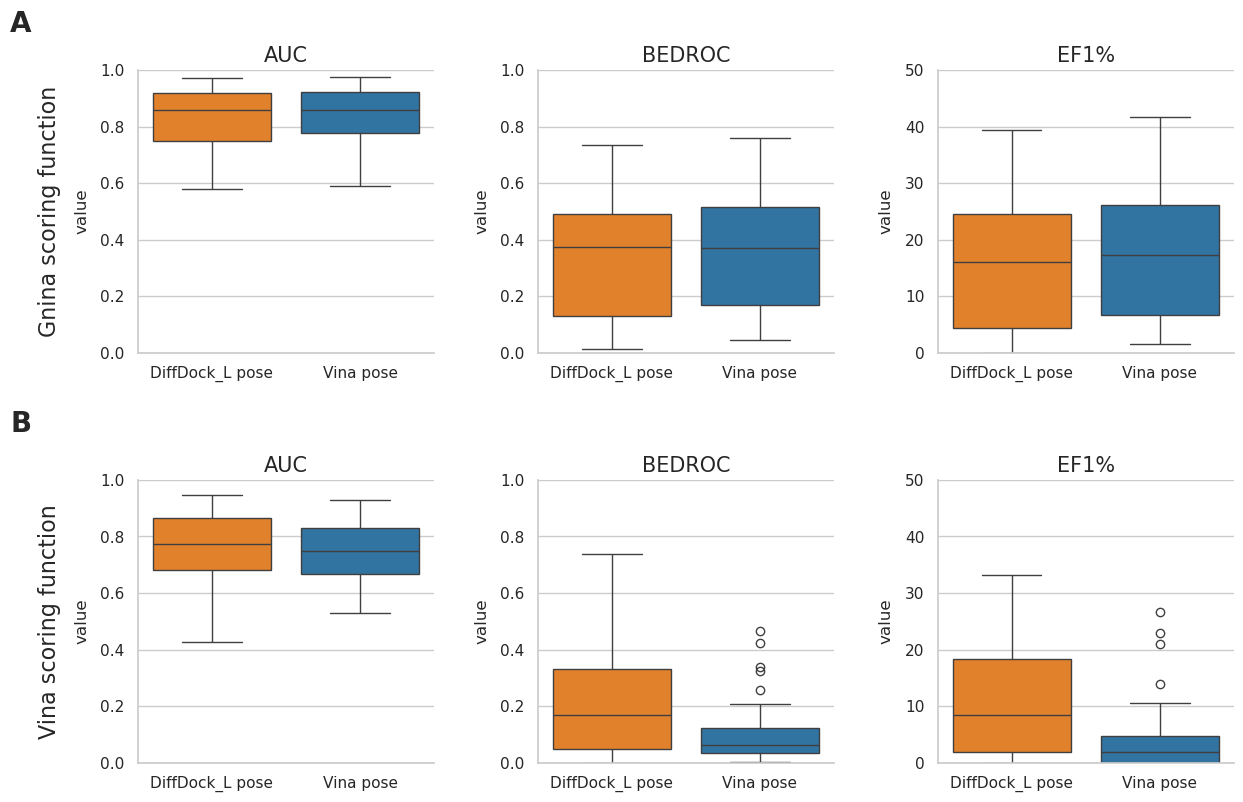

In [6]:
# Figure 2: Boxplot of virtual screening performance metrics
# save figure
sns.set_theme(font_scale=1, style='whitegrid')

g = sns.FacetGrid(df_plot, row='SF', col='metric', height=4, aspect=1, sharey=False, margin_titles=False, sharex=False)
g.map_dataframe(sns.boxplot, x='Docking_type', y='value', order=['DiffDock_L pose', 'Vina pose'], hue_order=['DiffDock_L pose', 'Vina pose'], palette=['tab:orange', 'tab:blue'], hue='Docking_type', legend=False)
g.set_titles('{col_name}', size=15)
g.set_xlabels('')
g.fig.subplots_adjust(wspace=0.35, hspace=0.45)

for ax in g.axes.flat:
    ax.set(ylim=(0, 1))
    ax.set_ylabel(ylabel='value', fontsize=12, labelpad=8)

g.axes[0,0].set(ylim=(0, 1))
g.axes[1,0].set(ylim=(0, 1))

g.axes[0,1].set(ylim=(0, 1))
g.axes[1,1].set(ylim=(0, 1))

g.axes[0,2].set(ylim=(0, 50))
g.axes[1,2].set(ylim=(0, 50))

g.axes[0,0].annotate('Gnina scoring function', xy=(-0.3, 0.5), xycoords='axes fraction', fontsize=16, ha='center', va='center', rotation=90)
g.fig.text(-0.035, 1, 'A', fontsize=20, fontweight='bold')
g.axes[1,0].annotate('Vina scoring function', xy=(-0.3, 0.5), xycoords='axes fraction', fontsize=16, ha='center', va='center', rotation=90)
g.fig.text(-0.035, 0.5, 'B', fontsize=20, fontweight='bold')

plt.savefig(os.path.join(outdir, "Fig2_vs_metrics.png"), dpi=300, bbox_inches='tight')

#### Scatterplot of BEDROC scores (Figure 3)

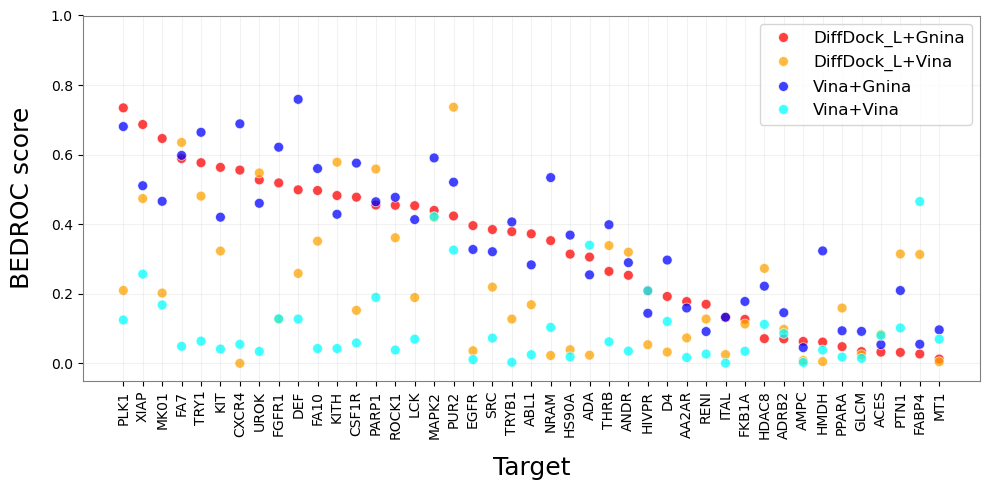

In [20]:
# plot the performnace for each target, score by docking settings
import matplotlib.pyplot as plt
import seaborn as sns

bedroc_df = pd.read_csv(os.path.join(outdir, "dudez_bedroc.csv"), index_col=0)

# formatting
bedroc_df = bedroc_df[["diffdock_L+gnina", "diffdock_L+vina", "vina+gnina", "vina+vina"]]
format_dict = {'vina+vina': 'Vina+Vina', 'vina+gnina': 'Vina+Gnina', 
               'diffdock_L+vina': 'DiffDock_L+Vina', 'diffdock_L+gnina': 'DiffDock_L+Gnina'}
bedroc_df.columns = bedroc_df.columns.map(format_dict)
bedroc_df.index = bedroc_df.index.str.upper()
bedroc_df.sort_values(by="DiffDock_L+Gnina", inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=bedroc_df, ax=ax, s=50, alpha=0.75, markers=['o', 'o', 'o', 'o'], palette=['red', 'orange', 'blue', 'cyan'])

ax.grid(linestyle='-', alpha=0.1, color='gray')
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.set_ylim(-0.05, 1)
plt.xticks(rotation=90)
plt.xlabel("Target", fontsize=18, labelpad=12)
plt.ylabel("BEDROC score", fontsize=18, labelpad=12)
plt.legend(fontsize=12)
plt.savefig(os.path.join(outdir, "Fig3_BEDROC_scatterplot.png"), dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

#### AUC Correlation scatterplot (Figure 4)

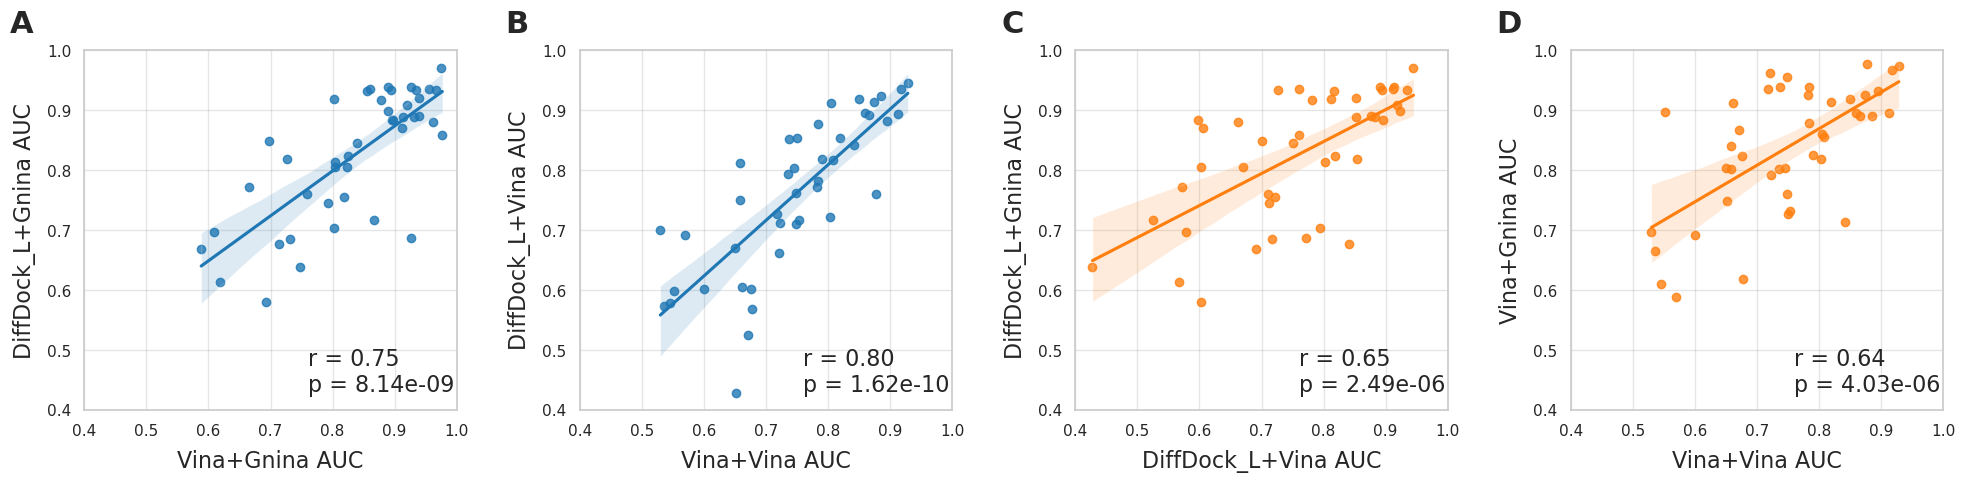

In [9]:
# Figure 4: Correlation between AUC values of different docking setups
from scipy.stats import pearsonr

pairs = [('vina+gnina', 'diffdock_L+gnina'), ('vina+vina', 'diffdock_L+vina'), 
         ('diffdock_L+vina', 'diffdock_L+gnina'), ('vina+vina', 'vina+gnina')]
pairs_labels = [('Vina+Gnina AUC', 'DiffDock_L+Gnina AUC'), ('Vina+Vina AUC', 'DiffDock_L+Vina AUC'), 
                ('DiffDock_L+Vina AUC', 'DiffDock_L+Gnina AUC'), ('Vina+Vina AUC', 'Vina+Gnina AUC')]

indices = ['A', 'B', 'C', 'D']
color_palette = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange']

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
fig.subplots_adjust(wspace=0.5)
for i in range(4):
    ax[i].grid(linestyle='-', alpha=0.2, color='gray')
    sns.regplot(data=auc_df, x=pairs[i][0], y=pairs[i][1], ax=ax[i], color=color_palette[i])
    r, p = pearsonr(auc_df[pairs[i][0]], auc_df[pairs[i][1]])
    ax[i].text(0.6, 0.05, f'r = {r:.2f}\np = {"{:.2e}".format(p)}', transform=ax[i].transAxes, fontsize=16)
    ax[i].text(-0.2, 1.05, indices[i], transform=ax[i].transAxes, fontsize=22, fontweight='bold')
    ax[i].set_xlabel(pairs_labels[i][0], fontsize=16, labelpad=8)
    ax[i].set_ylabel(pairs_labels[i][1], fontsize=16, labelpad=8)
    ax[i].set_ylim(0.4, 1)
    ax[i].set_xlim(0.4, 1)

plt.tight_layout()
plt.savefig(os.path.join(outdir, 'Fig4_AUC_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()


#### Correlation between scores of the same compounds sampled with Vina and DiffDock-L (Figure 5, S2, S3)

In [9]:
from utils.analysis_utils import get_label_dict, get_id_score_label

diffdock_L_docking_dir = os.path.join(DATA_PATH, "docking_poses", "DiffDock_L")
vina_docking_dir = os.path.join(DATA_PATH, "docking_poses", "Vina")
label_dir = os.path.join(DATA_PATH, "dudez")
outdir = os.path.join(DATA_PATH, "analysis", "id_score_label")
os.makedirs(outdir, exist_ok=True)

targets = os.listdir(label_dir)

def get_it(target):
    """
    Check virtual screening performance of different docking settings on a target.
    """
    # get label_dict
    label_dict = get_label_dict(label_dir, target)

    # DiffDock_L
    diffdock_L_input_file_gnina = os.path.join(diffdock_L_docking_dir, target.upper(), "score", f"poses_minimized_gnina.sdf")
    diffdock_L_gnina_outfile = os.path.join(outdir, f"{target.lower()}_diffdock_L_gnina.csv")

    diffdock_L_input_file_vina = os.path.join(diffdock_L_docking_dir, target.upper(), "score", f"poses_minimized_vina.sdf")
    diffdock_L_vina_outfile = os.path.join(outdir, f"{target.lower()}_diffdock_L_vina.csv")

    # Vina
    vina_input_file_vina = os.path.join(vina_docking_dir, target.lower(), f"{target.lower()}_docked.sdf")
    vina_vina_outfile = os.path.join(outdir, f"{target.lower()}_vina_vina.csv")

    vina_input_file_gnina = os.path.join(vina_docking_dir, target.lower(), "score", f"{target.lower()}_gnina.sdf")
    vina_gnina_outfile = os.path.join(outdir, f"{target.lower()}_vina_gnina.csv")

    if os.path.exists(diffdock_L_gnina_outfile) and os.path.exists(diffdock_L_vina_outfile) and os.path.exists(vina_vina_outfile) and os.path.exists(vina_gnina_outfile):
        return
    else:
        _ = get_id_score_label(diffdock_L_input_file_gnina, "diffdock_L", "gnina", label_dict, diffdock_L_gnina_outfile)
        _ = get_id_score_label(diffdock_L_input_file_vina, "diffdock_L", "vina", label_dict, diffdock_L_vina_outfile)
        _ = get_id_score_label(vina_input_file_vina, "vina", "vina", label_dict, vina_vina_outfile)
        _ = get_id_score_label(vina_input_file_gnina, "vina", "gnina", label_dict, vina_gnina_outfile)
        
    return


with Pool(processes=43) as pool:
    results = pool.map(get_it, targets)

In [23]:
# plot all targets in the same plot
from scipy.stats import pearsonr

indir = os.path.join(DATA_PATH, "analysis", "id_score_label")
targets = set([t.split("_")[0] for t in os.listdir(indir) if os.path.isfile(os.path.join(indir, t))])
assert len(targets) == 43

targets = ["ada", "urok"]  # uncomment to plot for specific targets

pose_sampling_1 = ["diffdock_L", "DiffDock_L"]
pose_sampling_2 = ["vina", "Vina"]
scoring = "vina"   # choose between "gnina" and "vina" scoring functions

corr_data = pd.DataFrame()
for target in sorted(targets):
    infile1 = os.path.join(indir, f"{target}_{pose_sampling_1[0]}_{scoring}.csv")
    infile2 = os.path.join(indir, f"{target}_{pose_sampling_2[0]}_{scoring}.csv")

    infile1_df = pd.read_csv(infile1, header=0, index_col=0)
    infile1_df.rename(columns={"score": f"score_{pose_sampling_1[0]}_{scoring}"}, inplace=True)
    infile2_df = pd.read_csv(infile2, header=0, index_col=0).loc[:, ["score"]]
    infile2_df.rename(columns={"score": f"score_{pose_sampling_2[0]}_{scoring}"}, inplace=True)
    
    merged = infile1_df.merge(infile2_df, left_index=True, right_index=True)
    merged.sort_values(by="label", inplace=True)
    merged.dropna(inplace=True)
    merged["target"] = target.upper()
    corr_data = pd.concat([corr_data, merged], axis=0)

corr_data["label"].astype(int)
corr_data["label"] = corr_data["label"].apply(lambda x: "active compound" if x == 1 else "decoy")

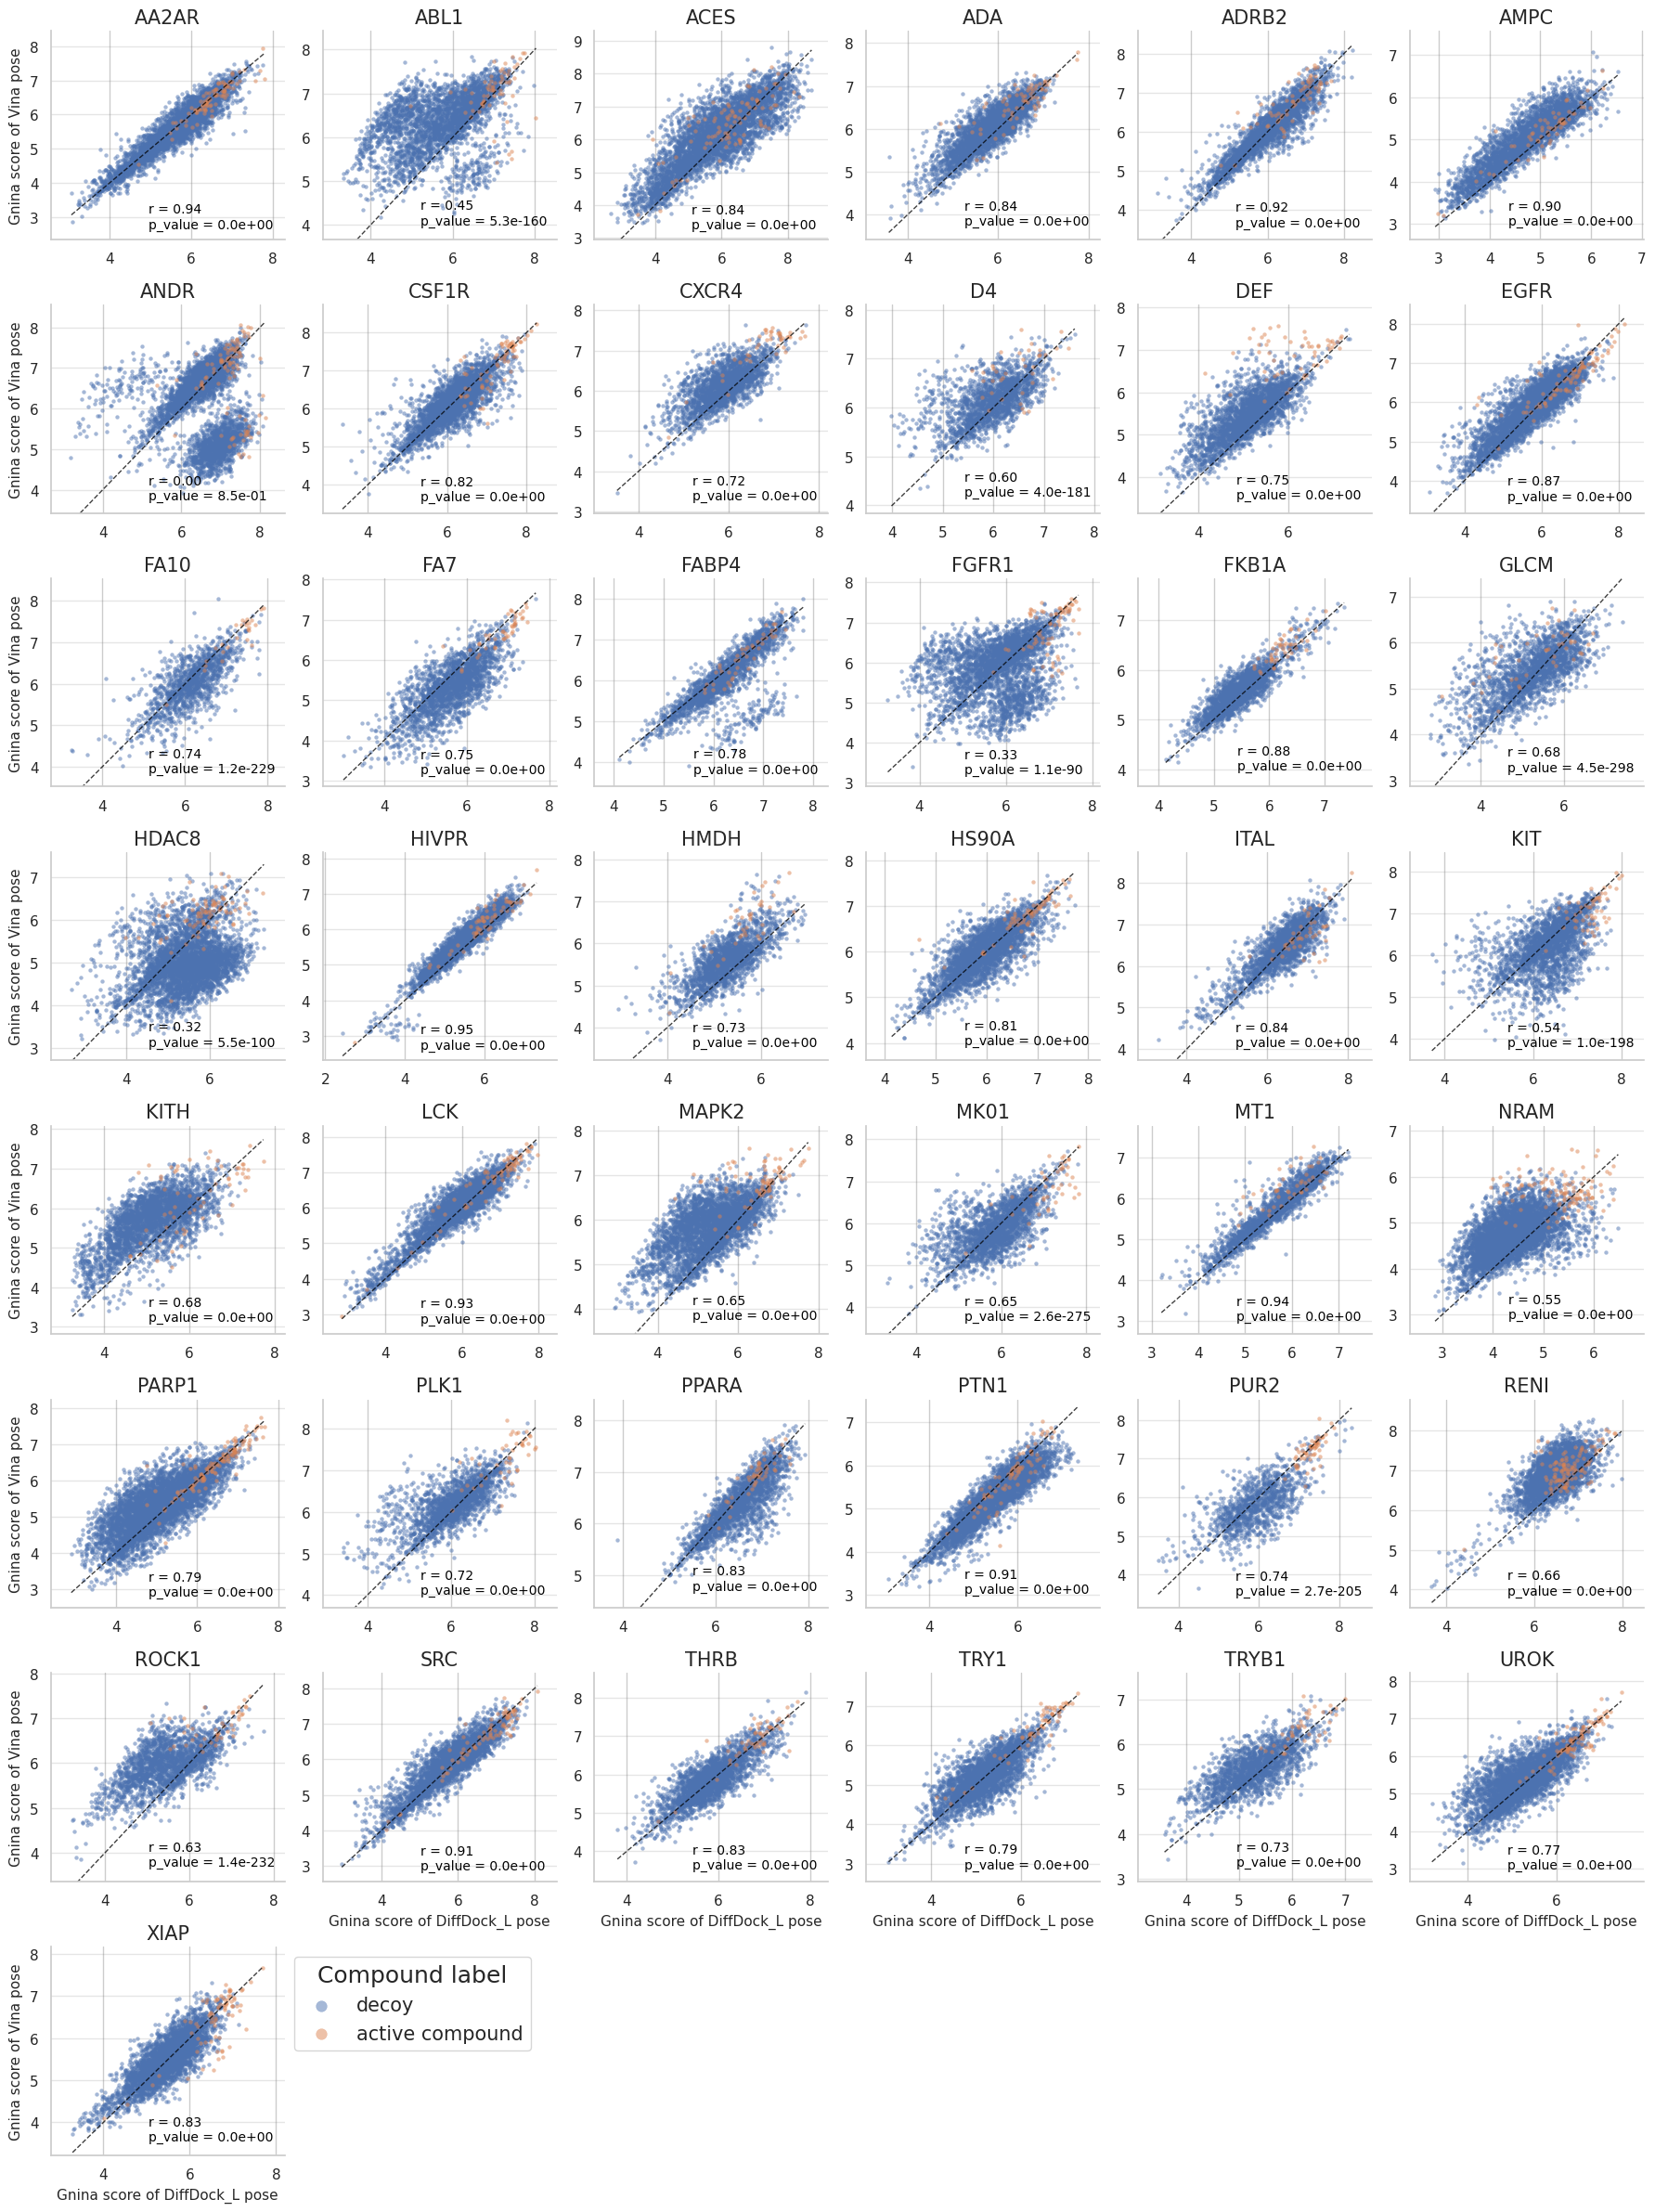

In [22]:
# Figure S2 & S3
# plot for all targets
g = sns.FacetGrid(corr_data, col="target", hue="label", col_wrap=6, height=3, sharey=False, sharex=False)
g.map(sns.scatterplot, f"score_{pose_sampling_1[0]}_{scoring}", f"score_{pose_sampling_2[0]}_{scoring}", s=8, alpha=0.5, edgecolor=None)
g.set_titles("{col_name}", size=15)
g.set_xlabels(f"{scoring.capitalize()} score of {pose_sampling_1[1]} pose", fontsize=11, labelpad=5)
g.set_ylabels(f"{scoring.capitalize()} score of {pose_sampling_2[1]} pose", fontsize=11, labelpad=5)

axs = g.axes.flatten()
for ax in axs:
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for ax in g.axes:
    target_data = corr_data[corr_data["target"] == ax.title.get_text()]
    x_min = target_data[f"score_{pose_sampling_1[0]}_{scoring}"].min()
    x_max = target_data[f"score_{pose_sampling_1[0]}_{scoring}"].max()
    y_min = target_data[f"score_{pose_sampling_2[0]}_{scoring}"].min()
    y_max = target_data[f"score_{pose_sampling_2[0]}_{scoring}"].max()
    ax.set_xlim([x_min-0.5, x_max+0.5])
    ax.set_ylim([y_min-0.5, y_max+0.5])
    ax.plot([x_min, x_max], [x_min, x_max], ls="--", color="black", linewidth=1, alpha=0.75)

    corr, p = pearsonr(target_data[f"score_{pose_sampling_1[0]}_{scoring}"], target_data[f"score_{pose_sampling_2[0]}_{scoring}"])
    p = "{:.1e}".format(p)
    ax.grid(axis='y', linestyle='-', alpha=0.2, color='gray')
    ax.text(x_min+2/5*abs(x_max-x_min), y_min+abs(y_max-y_min)/9, f"r = {corr:.2f}\np_value = {p}", ha='left', va='top', color='black', fontsize=10)

plt.tight_layout()
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Compound label", title_fontsize=18, fontsize=15, markerscale=3)
outdir = os.path.join(DATA_PATH, "analysis")
plt.savefig(os.path.join(outdir, f"FigS23_score_correlation_{scoring}.png"), dpi=300)
plt.show()

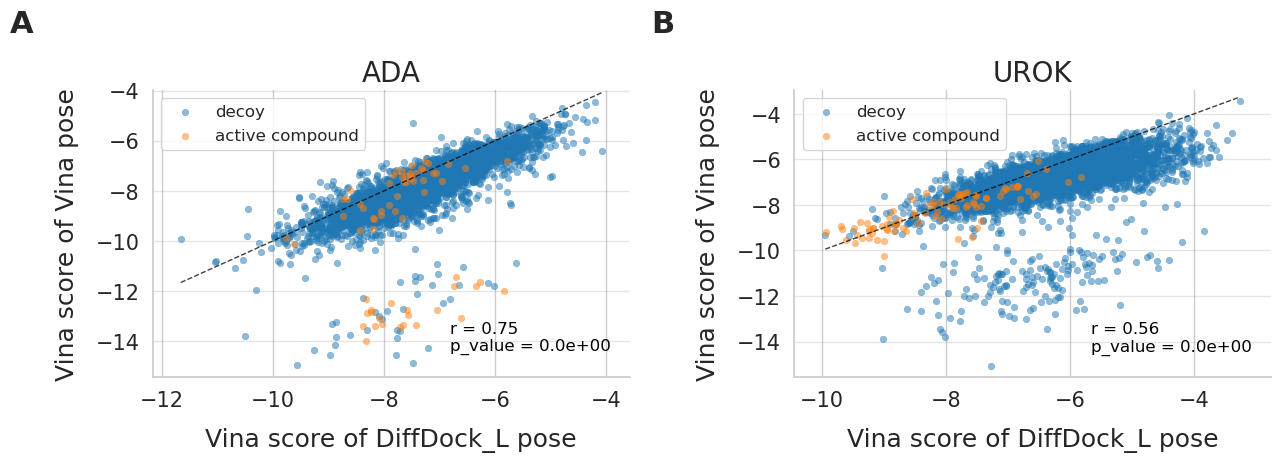

In [24]:
# Figure 5
# plot only for ADA and UROK
g = sns.FacetGrid(corr_data, col="target", hue="label", col_wrap=2, height=5, aspect=6.5/5, sharey=False, sharex=False, palette=["tab:blue", "tab:orange"])
g.map(sns.scatterplot, f"score_{pose_sampling_1[0]}_{scoring}", f"score_{pose_sampling_2[0]}_{scoring}", s=22, alpha=0.5, edgecolors=None)
g.figure.subplots_adjust(wspace=2)
g.set_titles("{col_name}", size=20)
g.set_xlabels(f"{scoring.capitalize()} score of {pose_sampling_1[1]} pose", fontsize=18, labelpad=12)
g.axes[0].set_ylabel(f"{scoring.capitalize()} score of {pose_sampling_2[1]} pose", fontsize=18, labelpad=12)
g.axes[1].set_ylabel(f"{scoring.capitalize()} score of {pose_sampling_2[1]} pose", fontsize=18, labelpad=12)
g.set_xticklabels(fontsize=15)
g.set_yticklabels(fontsize=15)

for i, ax in enumerate(g.axes):
    target_data = corr_data[corr_data["target"] == ax.title.get_text()]
    x_min = target_data[f"score_{pose_sampling_1[0]}_{scoring}"].min()
    x_max = target_data[f"score_{pose_sampling_1[0]}_{scoring}"].max()
    y_min = target_data[f"score_{pose_sampling_2[0]}_{scoring}"].min()
    y_max = target_data[f"score_{pose_sampling_2[0]}_{scoring}"].max()
    ax.set_xlim([x_min-0.5, x_max+0.5])
    ax.set_ylim([y_min-0.5, y_max+0.5])
    ax.plot([x_min, x_max], [x_min, x_max], ls="--", color="black", linewidth=1, alpha=0.75)

    corr, p = pearsonr(target_data[f"score_{pose_sampling_1[0]}_{scoring}"], target_data[f"score_{pose_sampling_2[0]}_{scoring}"])
    p = "{:.1e}".format(p)
    ax.text(x_min+3.2/5*abs(x_max-x_min), y_min+abs(y_max-y_min)/6, f"r = {corr:.2f}\np_value = {p}", ha='left', va='top', color='black', fontsize=12)
    ax.legend(loc="upper left", title_fontsize=12, fontsize=12, markerscale=1)
    ax.grid(axis='y', linestyle='-', alpha=0.2, color='gray')
    ax.text(-0.3, 1.2, list(("A", "B"))[i], transform=ax.transAxes, fontsize=22, fontweight='bold')

plt.tight_layout()
outdir = os.path.join(DATA_PATH, "analysis")
plt.savefig(os.path.join(outdir, "Fig5_Vina_score_correlation_ADA_UROK.png"), dpi=300)
plt.show()

# Hedging strategies (Table 2)

In [25]:
# extract best poses of each docking setting
from utils.analysis_utils import take_best_poses

diffdock_l_indir = os.path.join(DATA_PATH, "docking_poses", "DiffDock_L")
vina_indir = os.path.join(DATA_PATH, "docking_poses", "Vina")
outdir = os.path.join(DATA_PATH, "analysis", "best_poses")
os.makedirs(outdir, exist_ok=True)

targets = os.listdir(diffdock_l_indir)

def get_it(target):

    prefix = target.upper()

    ddl_vina_input_file = os.path.join(diffdock_l_indir, target.upper(), "score", f"poses_minimized_vina.sdf")
    take_best_poses(ddl_vina_input_file, "diffdock_L", "vina", outdir, prefix=prefix)

    ddl_gnina_input_file = os.path.join(diffdock_l_indir, target.upper(), "score", f"poses_minimized_gnina.sdf")
    take_best_poses(ddl_gnina_input_file, "diffdock_L", "gnina", outdir, prefix=prefix)

    vina_vina_input_file = os.path.join(vina_indir, target.lower(), f"{target.lower()}_docked.sdf")
    take_best_poses(vina_vina_input_file, "vina", "vina", outdir, prefix=prefix)

    vina_gnina_input_file = os.path.join(vina_indir, target.lower(), "score", f"{target.lower()}_gnina.sdf")
    take_best_poses(vina_gnina_input_file, "vina", "gnina", outdir, prefix=prefix)

    return

with Pool(processes=43) as pool:
    it = pool.map(get_it, targets)

Read PUR2 poses_minimized_vina.sdf: 37003 poses
Read FA10 poses_minimized_vina.sdf: 40546 poses
Read D4 poses_minimized_vina.sdf: 58042 poses
Read HMDH poses_minimized_vina.sdf: 59590 poses
Read TRYB1 poses_minimized_vina.sdf: 58890 poses
Read GLCM poses_minimized_vina.sdf: 66593 poses
Read MT1 poses_minimized_vina.sdf: 67793 poses
Read ROCK1 poses_minimized_vina.sdf: 65541 poses
Read MK01 poses_minimized_vina.sdf: 66714 poses
Read PLK1 poses_minimized_vina.sdf: 67531 poses
Read FA7 poses_minimized_vina.sdf: 66666 poses
Read FABP4 poses_minimized_vina.sdf: 70958 poses
Read CXCR4 poses_minimized_vina.sdf: 69195 poses
Read FKB1A poses_minimized_vina.sdf: 72314 poses
Read ITAL poses_minimized_vina.sdf: 69149 poses
Read PPARA poses_minimized_vina.sdf: 75681 poses
Read PUR2 poses_minimized_gnina.sdf: 36987 poses
Read KIT poses_minimized_vina.sdf: 81098 poses
Read DEF poses_minimized_vina.sdf: 85150 poses
Read THRB poses_minimized_vina.sdf: 83325 poses
Read FA10 poses_minimized_gnina.sdf: 40

In [26]:
from rdkit.Chem import PandasTools
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
import rdkit.ML.Scoring.Scoring
from utils.analysis_utils import get_label_dict

best_pose_path = os.path.join(DATA_PATH, "analysis", "best_poses")
label_dir = os.path.join(DATA_PATH, "dudez")
outdir = os.path.join(DATA_PATH, "analysis")

targets = os.listdir(label_dir)

vs = list()
recovery = list()

for target in tqdm(targets):
    ### GET MOL|ID|RANK

    df = pd.DataFrame()

    for docking in ["vina", "diffdock_l"]:
        for scoring in ["vina", "gnina"]:

            input_file = os.path.join(best_pose_path, f"{target.upper()}_{docking}_{scoring}_best_poses.sdf")

            # suppress RDKit warning
            lg = RDLogger.logger()
            lg.setLevel(RDLogger.CRITICAL)

            frame = PandasTools.LoadSDF(input_file, molColName='molecule')
            frame["score"] = frame["score"].astype(float)
            frame = frame.sort_values(by="score", ascending=False if scoring == "gnina" else True).reset_index(drop=True)
            frame[f"{docking}_{scoring}_rank"] = frame.index + 1
            if df.empty:
                df = frame[["ID", "molecule", f"{docking}_{scoring}_rank"]]
            else:
                df = df.merge(frame[["ID", f"{docking}_{scoring}_rank"]], on="ID", how="outer")
                id_mol = dict(zip(frame["ID"], frame["molecule"]))
                df["molecule"] = df["molecule"].fillna(df["ID"].map(id_mol))

    ### LABELING
    label_dict = get_label_dict(label_dir, target)
    df["label"] = df["ID"].apply(lambda x: label_dict[x.split("_")[0]])

    ### GET MURCKO SCAFFOLD
    df["scaffold"] = df["molecule"].apply(MurckoScaffold.GetScaffoldForMol)
    df["scaffold_smiles"] = df["scaffold"].apply(Chem.MolToSmiles)

    ### CONSENSUS
    df["best_rank"] = df[["vina_vina_rank", "diffdock_l_vina_rank", "vina_gnina_rank", "diffdock_l_gnina_rank"]].min(axis=1)
    df["average_rank"] = df[["vina_vina_rank", "diffdock_l_vina_rank", "vina_gnina_rank", "diffdock_l_gnina_rank"]].mean(axis=1, skipna=True)
    df["average_rank_VinaSF"] = df[["vina_vina_rank", "diffdock_l_vina_rank"]].mean(axis=1, skipna=True)
    df["average_rank_GninaSF"] = df[["vina_gnina_rank", "diffdock_l_gnina_rank"]].mean(axis=1, skipna=True)
    df["best_rank_VinaSF"] = df[["vina_vina_rank", "diffdock_l_vina_rank"]].min(axis=1)
    df["best_rank_GninaSF"] = df[["vina_gnina_rank", "diffdock_l_gnina_rank"]].min(axis=1)

    ### SAVE
    df.drop(columns=["molecule", "scaffold"], inplace=True)

    # VS PERFORMANCE OF THE STRATEGIES
    for consensus in ["average_rank", "best_rank", "average_rank_VinaSF", "average_rank_GninaSF", "best_rank_VinaSF", "best_rank_GninaSF"]:
        score_df = df[["ID", consensus, "label"]].sort_values(by=consensus, ascending=True)
        scores = score_df[[consensus, "label"]].values
        label_col = 1
        auc_score = rdkit.ML.Scoring.Scoring.CalcAUC(scores, label_col)
        ef_frac = [0.01, 0.05]  # EF1%, EF5%
        ef_scores = rdkit.ML.Scoring.Scoring.CalcEnrichment(scores, label_col, ef_frac)    
        bedroc_alpha = 80.5
        bedroc_score = rdkit.ML.Scoring.Scoring.CalcBEDROC(scores, label_col, bedroc_alpha)

        vs.append((target, consensus, auc_score, bedroc_score, ef_scores[0], ef_scores[1]))

    # RECOVERY RATE
    for k in [0.001, 0.005, 0.01, 0.05]:
        top_k = int(k * len(df))
        for ranking in ["vina_vina_rank", "diffdock_l_vina_rank", "vina_gnina_rank", "diffdock_l_gnina_rank", "best_rank", 
                        "average_rank", "average_rank_VinaSF", "average_rank_GninaSF", "best_rank_VinaSF", "best_rank_GninaSF"]:
            frame = df.sort_values(by=ranking, ascending=True).head(top_k)
            recovered_scaffolds = len(frame[frame["label"]==1]["scaffold_smiles"].unique())
            total_scaffolds = len(df[df["label"]==1]["scaffold_smiles"].unique())
            scaffold_recovery = recovered_scaffolds / total_scaffolds
            recovery.append((target, k, ranking, recovered_scaffolds, total_scaffolds, scaffold_recovery))

vs_df = pd.DataFrame(vs, columns=["target", "consensus", "AUC", "BEDROC", "EF1%", "EF5%"])
vs_df.to_csv(os.path.join(outdir, "vs_consensus.csv"), index=False)

recovery_df = pd.DataFrame(recovery, columns=["target", "top-k", "ranking", "recovered_scaffolds", "total_scaffolds", "scaffold_recovery"])
recovery_df.to_csv(os.path.join(outdir, "vs_recovery_rate.csv"), index=False)

  0%|          | 0/43 [00:00<?, ?it/s]

100%|██████████| 43/43 [05:35<00:00,  7.80s/it]


In [27]:
# Table 2: mean and standard deviation of the metrics for all targets
vs_df = pd.read_csv(os.path.join(outdir, "vs_consensus.csv"))
vs_df_mean = vs_df.drop(columns="target").groupby("consensus").mean()
vs_df_std = vs_df.drop(columns="target").groupby("consensus").std()
pd.concat([vs_df_mean.add_suffix("_mean"), vs_df_std.add_suffix("_std")], axis=1).sort_index(axis=1)

,AUC_mean,AUC_std,BEDROC_mean,BEDROC_std,EF1%_mean,EF1%_std,EF5%_mean,EF5%_std
consensus,,,,,,,,
average_rank,0.834734,0.101262,0.347218,0.226342,17.222743,12.449018,8.411532,4.614439
average_rank_GninaSF,0.844142,0.101510,0.376935,0.223672,19.330269,13.244365,8.957641,4.294954
average_rank_VinaSF,0.770801,0.120604,0.222168,0.192985,10.327067,9.753866,6.101387,4.217454
best_rank,0.841460,0.102046,0.279630,0.158697,12.979166,8.760285,8.104038,4.024796
best_rank_GninaSF,0.848231,0.101487,0.353079,0.205899,17.492395,11.602113,9.168503,4.379719
best_rank_VinaSF,0.767989,0.113771,0.179655,0.148357,8.118841,7.768091,5.318626,3.429129


In [28]:
# Table 1&2: mean and standard deviation of active scaffold recovery rates
recovery_df = pd.read_csv(os.path.join(outdir, "vs_recovery_rate.csv"))
recovery_df = recovery_df[recovery_df["top-k"]==0.01]
recovery_mean = recovery_df.groupby("ranking")["scaffold_recovery"].mean()
recovery_std = recovery_df.groupby("ranking")["scaffold_recovery"].std()
pd.concat([recovery_mean.rename("mean"), recovery_std.rename("std")], axis=1)

,mean,std
ranking,,
average_rank,0.180247,0.123413
average_rank_GninaSF,0.206361,0.140239
average_rank_VinaSF,0.109063,0.100966
best_rank,0.147289,0.103329
best_rank_GninaSF,0.191868,0.126228
best_rank_VinaSF,0.083063,0.077569
diffdock_l_gnina_rank,0.175393,0.127382
diffdock_l_vina_rank,0.111737,0.101833
vina_gnina_rank,0.193173,0.125247


# Pose analysis

### Check with PoseBusters & generate PLIF

In [ ]:
# execute the following scripts in the following order: 
# posebusters_poses.py
# plif_cal_dudez.py
# merge_plifs.py (merge_plifs_utils.py)

### Analysis

In [2]:
plif_dir = os.path.join(DATA_PATH, "plif")
pb_dir = os.path.join(DATA_PATH, "posebusters")
mol_dir = os.path.join(DATA_PATH, "analysis", "best_poses")
label_dir = os.path.join(DATA_PATH, "dudez")

outdir = os.path.join(DATA_PATH, "analysis")
os.makedirs(outdir, exist_ok=True)

# store all the paths in a dictionary
paths = dict()
paths["plif_dir"] = plif_dir
paths["pb_dir"] = pb_dir
paths["mol_dir"] = mol_dir
paths["label_dir"] = label_dir
paths["outdir"] = outdir

In [3]:
### PB_VALID & PLIF_SIM ANALYSIS ###
from utils.analysis_utils import get_label_dict, get_pb_valid, get_plif_sim, get_morgan_sim, keep_actives

ignored_interactions = ["VdWContact", "FaceToFace", "EdgeToFace"]
pa_outdir = os.path.join(outdir, "pose_analysis")
os.makedirs(pa_outdir, exist_ok=True)

targets = os.listdir(label_dir)
assert len(targets) == 43

sim_all = pd.DataFrame()

for target in tqdm(targets):

    if os.path.exists(os.path.join(pa_outdir, f"{target.upper()}_sim.csv")):
        sim = pd.read_csv(os.path.join(pa_outdir, f"{target.upper()}_sim.csv"))
        sim_all = pd.concat([sim_all, sim], ignore_index=True)
        continue

    print(f"Processing {target.upper()}...")
    
    label_dict = get_label_dict(label_dir, target)

    morgan_sim = get_morgan_sim(target, paths, fps=["morgan"], active_only=False)

    sim = pd.DataFrame()
    query_vc_docking = pd.DataFrame()

    for docking in ["vina", "ddl"]:
        plif_sim, ref_df, query_df = get_plif_sim(target, docking, paths, ignored_interactions=ignored_interactions)
        if plif_sim is None:
            continue
        pb = get_pb_valid(target, docking, paths)

        plif_sim["pb_valid"] = plif_sim["pose_id"].map(pb["pb_valid"].to_dict())
        plif_sim["mol_id"] = plif_sim["pose_id"].map(lambda x: "_".join(x.split("_")[:-1]))
        morgan_sim_dict = morgan_sim.set_index(["mol_id", "ref_lig"])["morgan_sim"].to_dict()
        plif_sim["morgan_sim"] = plif_sim.set_index(["mol_id", "ref_lig"]).index.map(morgan_sim_dict)

        # keep only the active compounds
        plif_sim_actives = keep_actives(plif_sim, label_dict, "pose_id")
        query_df_actives = keep_actives(query_df, label_dict)   # generate label_id from index

        plif_sim_actives.rename(columns={f"plif_sim_{docking}": "plif_sim"}, inplace=True)
        plif_sim_actives["plif_sim"] = plif_sim_actives["plif_sim"].astype(float)
        plif_sim_actives["docking"] = docking
        sim = pd.concat([sim, plif_sim_actives])

    sim.to_csv(os.path.join(pa_outdir, f"{target.upper()}_sim.csv"))

    sim_all = pd.concat([sim_all, sim], ignore_index=True)

100%|██████████| 43/43 [00:12<00:00,  3.43it/s]


In [4]:
# exclude the reference ligands with too few interactions (threshold = 4)
from utils.analysis_utils import count_interactions

ignored_interactions = ["VdWContact", "FaceToFace", "EdgeToFace"]
targets = os.listdir(label_dir)
low_interactions = list()
li_thres = 4

for target in tqdm(targets):
    working_dir = os.path.join(plif_dir, target.upper())
    ref_plif = pd.read_csv(os.path.join(working_dir, "ref_plifs.csv"), header=[0, 1], index_col=0)
    ref_plif.columns.names = ["protein", "interaction"]
    # drop the interactions to ignore
    if ignored_interactions:
        to_drop = ref_plif.columns.get_level_values("interaction").isin(ignored_interactions)
        ref_plif = ref_plif.drop(columns=ref_plif.columns[to_drop])
    ref_plif["n_interactions"] = count_interactions(ref_plif, ignored_interactions=ignored_interactions)
    low_interactions.append((target, ref_plif[ref_plif["n_interactions"] < li_thres].index.tolist()))

low_interactions_ref = list()
for t, ref in low_interactions:
    low_interactions_ref.extend(ref)

# drop the rows with ref_lig_vina or ref_lig_ddl in low_interactions_ref
sim_all_clean = sim_all[~sim_all["ref_lig"].isin(low_interactions_ref)].copy()
sim_all_clean["docking"] = sim_all_clean["docking"].map(dict({"vina": "Vina", "ddl": "DiffDock-L"}))

100%|██████████| 43/43 [00:00<00:00, 213.46it/s]


In [5]:
# count number of unique ref_ligs in total and with enough interactions (threshold >= 4)
n_ref_ligs_all = sim_all["ref_lig"].nunique()
n_ref_ligs_clean = sim_all_clean["ref_lig"].nunique()
n_ref_ligs_all, n_ref_ligs_clean

(2501, 2425)

### Plotting

#### Protein-ligand interaction preliminary (Figure S5, S6, S7A, S7B)

In [33]:
# check number of reference ligands for each target:
targets = [d for d in os.listdir(plif_dir) if os.path.isdir(os.path.join(plif_dir, d))]

ref_num = list()
for target in targets:
    working_dir = os.path.join(plif_dir, target.upper())
    ref_plif = pd.read_csv(os.path.join(working_dir, "ref_plifs.csv"), header=[0, 1], index_col=0)
    # drop ignored_interactions
    ignored_interactions = ["VdWContact", "FaceToFace", "EdgeToFace"]
    to_drop = list(set(ref_plif.columns.get_level_values(1)).intersection(ignored_interactions))
    ref_plif = ref_plif.drop(columns=to_drop, level=1)
    ref_plif["num_interactions"] = ref_plif.apply(lambda x: x.sum(), axis=1)
    ref_num.append((target, ref_plif.shape[0], ref_plif["num_interactions"].tolist()))

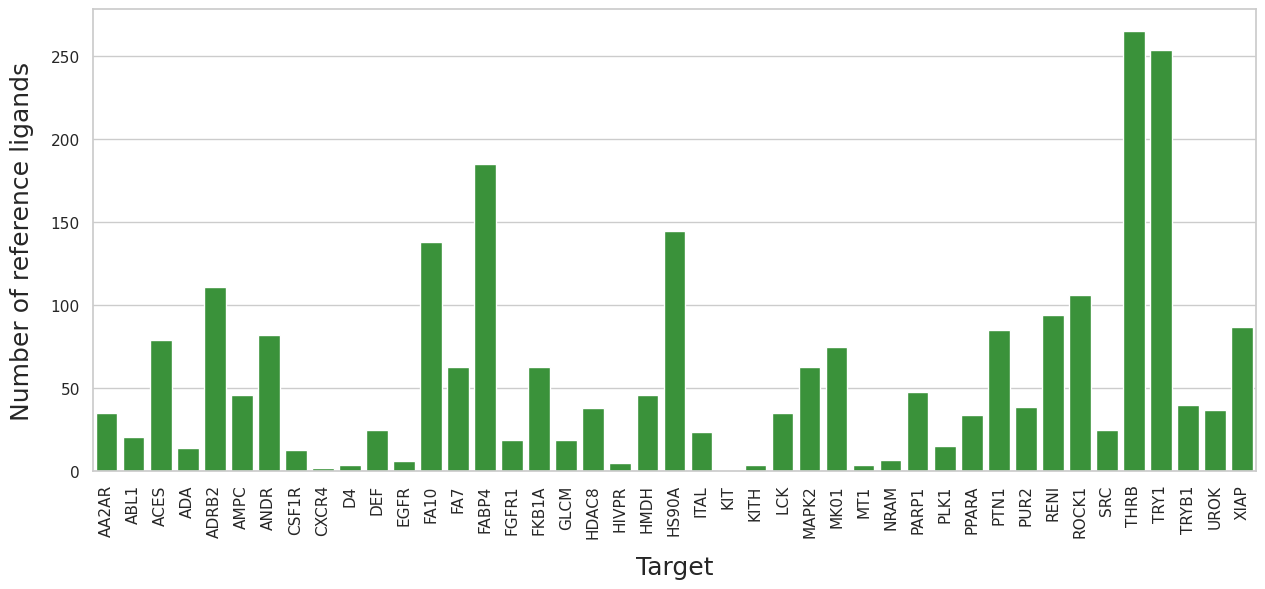

In [34]:
# Figure S5: Number of reference ligands for each target
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

ref_num_df = pd.DataFrame(ref_num, columns=["target", "ref_num", "n_interactions"])
sns.barplot(data=ref_num_df.sort_values(by="target"), x="target", y="ref_num", color="tab:green")
plt.xlabel("Target", fontsize=18, labelpad=12)
plt.ylabel("Number of reference ligands", fontsize=18, labelpad=12)
plt.xticks(rotation=90)
plt.gcf().set_size_inches(15, 6)
plt.savefig(os.path.join(outdir, "FigS5_num_ref_ligands.png"), dpi=300, bbox_inches="tight")
plt.show()

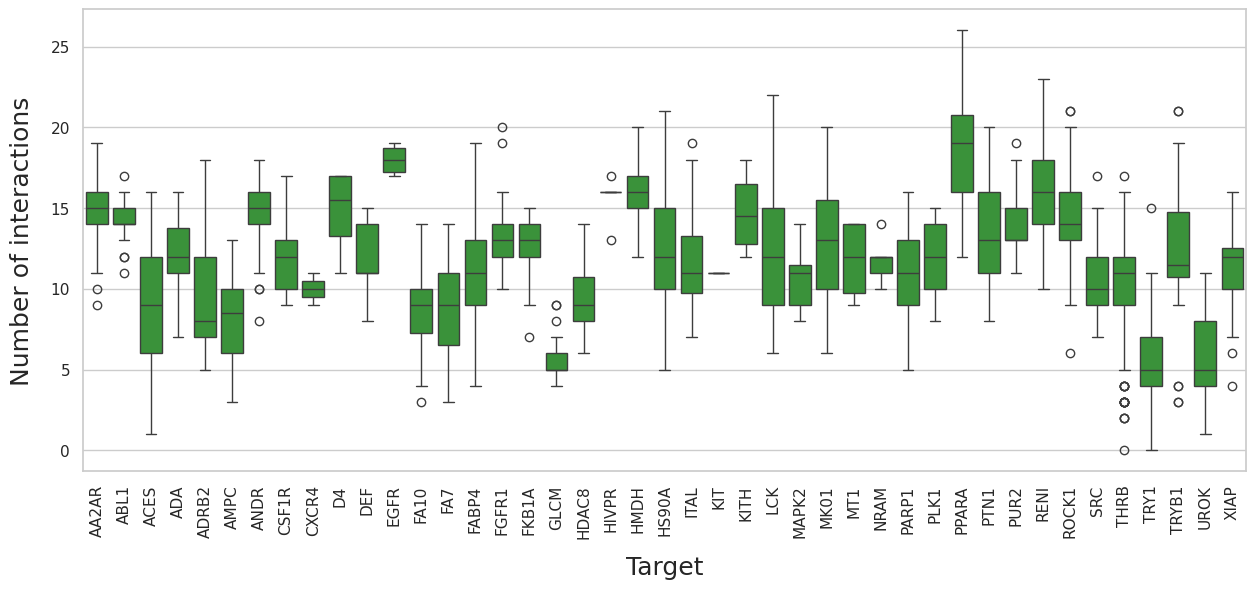

In [35]:
# Figure S6: Number of interactions in each reference ligand for each target
ref_num_df = pd.DataFrame(ref_num, columns=["target", "ref_num", "num_interactions"])
ref_num_df = ref_num_df.explode("num_interactions")
ref_num_df["num_interactions"] = ref_num_df["num_interactions"].astype(int)
sns.boxplot(data=ref_num_df.sort_values(by="target"), x="target", y="num_interactions", color="tab:green")
plt.xlabel("Target", fontsize=18, labelpad=12)
plt.ylabel("Number of interactions", fontsize=18, labelpad=12)
plt.xticks(rotation=90)
plt.gcf().set_size_inches(15, 6)
plt.savefig(os.path.join(outdir, "FigS6_num_interactions_ref_ligands.png"), dpi=300, bbox_inches="tight")
plt.show()

In [36]:
# read the plif data of the docked poses
from utils.analysis_utils import get_label_dict, keep_actives, count_interactions

docked_data = list()
ignored_interactions = ["VdWContact", "FaceToFace", "EdgeToFace"]

targets = [d for d in os.listdir(plif_dir) if os.path.isdir(os.path.join(plif_dir, d))]
assert len(targets) == 43, "Check targets."

for target in tqdm(targets):
    for docking in ["vina", "ddl"]:
        plif_df = pd.read_csv(os.path.join(plif_dir, target, f"docked_plifs_{docking}.csv"), header=[0, 1], index_col=0)
        to_drop = list(set(plif_df.columns.get_level_values(1)).intersection(set(ignored_interactions)))    # drop ignored interactions
        plif_df.drop(columns=to_drop, inplace=True, level=1)
        label_dict = get_label_dict(label_dir, target)
        plif_df = keep_actives(plif_df, label_dict)
        num_interactions = count_interactions(plif_df, ignored_interactions=ignored_interactions)
        docked_data.append((target, docking, num_interactions))

docked_data = pd.DataFrame(docked_data, columns=["target", "docking", "num_interactions"])
docked_data = docked_data.explode("num_interactions")
docked_data["num_interactions"] = docked_data["num_interactions"].astype(int)
docked_data.head()

100%|██████████| 43/43 [05:06<00:00,  7.12s/it]


,target,docking,num_interactions
0,HIVPR,vina,8
0,HIVPR,vina,8
0,HIVPR,vina,8
0,HIVPR,vina,7
0,HIVPR,vina,8


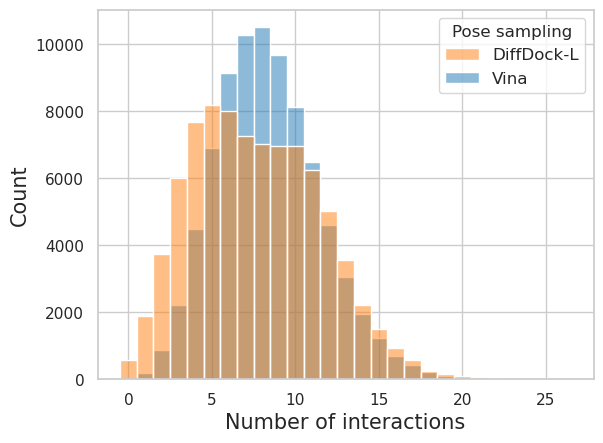

In [37]:
# Figure S7A: Number of interactions in docked poses for each docking method
fig, ax = plt.subplots()
sns.histplot(data=docked_data, x="num_interactions", hue="docking", hue_order=["ddl", "vina"], palette=["tab:orange", "tab:blue"], discrete=True, legend=True, ax=ax)   
legend = ax.get_legend()
labels, handles = legend.texts, legend.legend_handles
label_dict = {"vina": "Vina", "ddl": "DiffDock-L"}
labels = [label_dict[label.get_text()] for label in labels]
plt.legend(handles, labels, title="Pose sampling", title_fontsize=12, fontsize=12)
plt.xlabel("Number of interactions", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.savefig(os.path.join(outdir, "FigS7A_num_interactions_active_docked.png"), dpi=300, bbox_inches="tight")
plt.show()

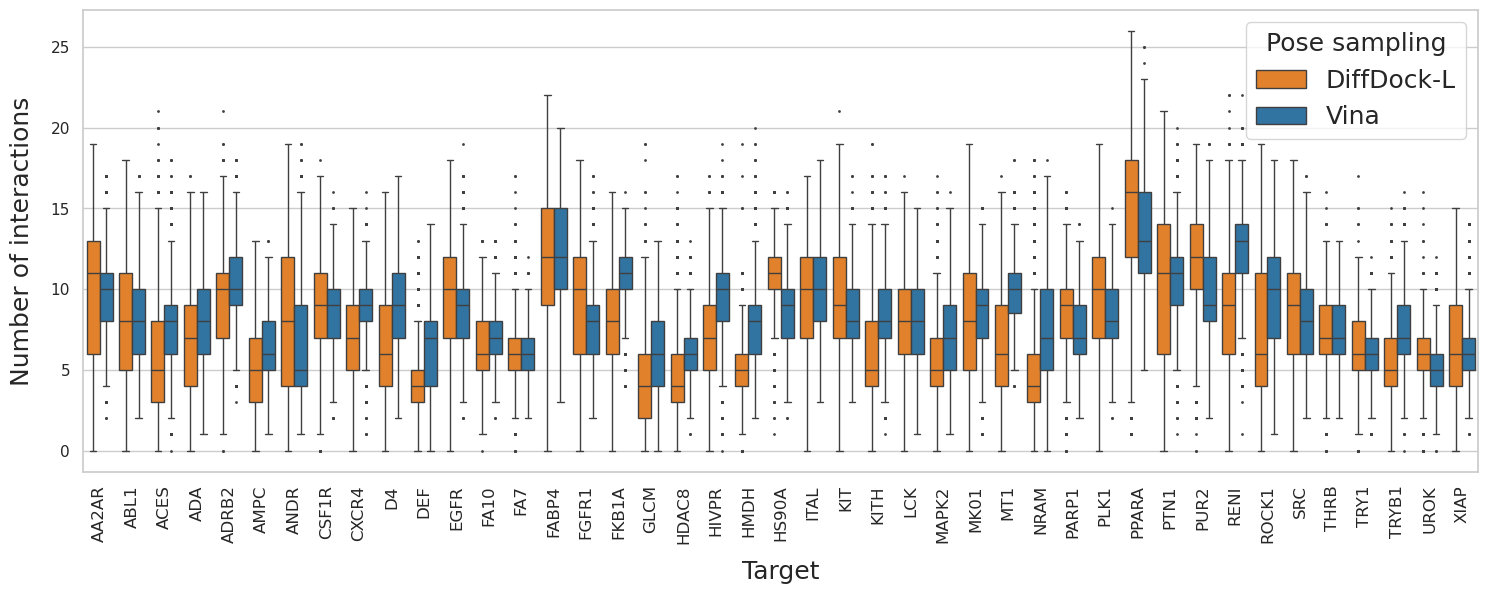

In [38]:
# Figure S7B: Number of interactions in docked poses for each target
fig, ax = plt.subplots()
sns.boxplot(data=docked_data.sort_values(by="target"), x="target", y="num_interactions", hue="docking", palette=["tab:orange", "tab:blue"], flierprops={'markersize': 1})
plt.xlabel("Target", fontsize=18, labelpad=12)
plt.ylabel("Number of interactions", fontsize=18, labelpad=12)
legend = ax.get_legend()
labels, handles = legend.texts, legend.legend_handles
label_dict = {"vina": "Vina", "ddl": "DiffDock-L"}
labels = [label_dict[label.get_text()] for label in labels]
plt.legend(handles, labels, title="Pose sampling", title_fontsize=18, fontsize=18)
plt.xticks(rotation=90)
fig.set_size_inches(18, 6)
plt.xticks(fontsize=12)
plt.savefig(os.path.join(outdir, "FigS7B_num_interactions_active_docked.png"), dpi=300, bbox_inches="tight")
plt.show()

#### PB_valid & PLIF_sim (Table 3, Figure S1, S4A, S4B)

In [6]:
# Table 3, Figure S4A
from utils.analysis_utils import plot_pb_valid_plif_sim

stat_all, _ = plot_pb_valid_plif_sim(sim_all_clean, "all", os.path.join(outdir, "FigS4A_PBvalid_PLIFsim.png"))
pd.DataFrame(stat_all, columns=["target", "docking", "total_mol", "pb_valid_mol", "pb_valid_ratio", "pb_valid_50_mol",
                                "pb_valid_50_ratio", "pb_valid_85_mol", "pb_valid_85_ratio", "pb_valid_100_mol", "pb_valid_100_ratio"]).T

,0,1
target,all,all
docking,DiffDock-L,Vina
total_mol,2785,2790
pb_valid_mol,2772,2776
pb_valid_ratio,0.995332,0.994982
pb_valid_50_mol,2418,2670
pb_valid_50_ratio,0.868223,0.956989
pb_valid_85_mol,610,830
pb_valid_85_ratio,0.219031,0.297491
pb_valid_100_mol,139,203


100%|██████████| 43/43 [00:19<00:00,  2.25it/s]


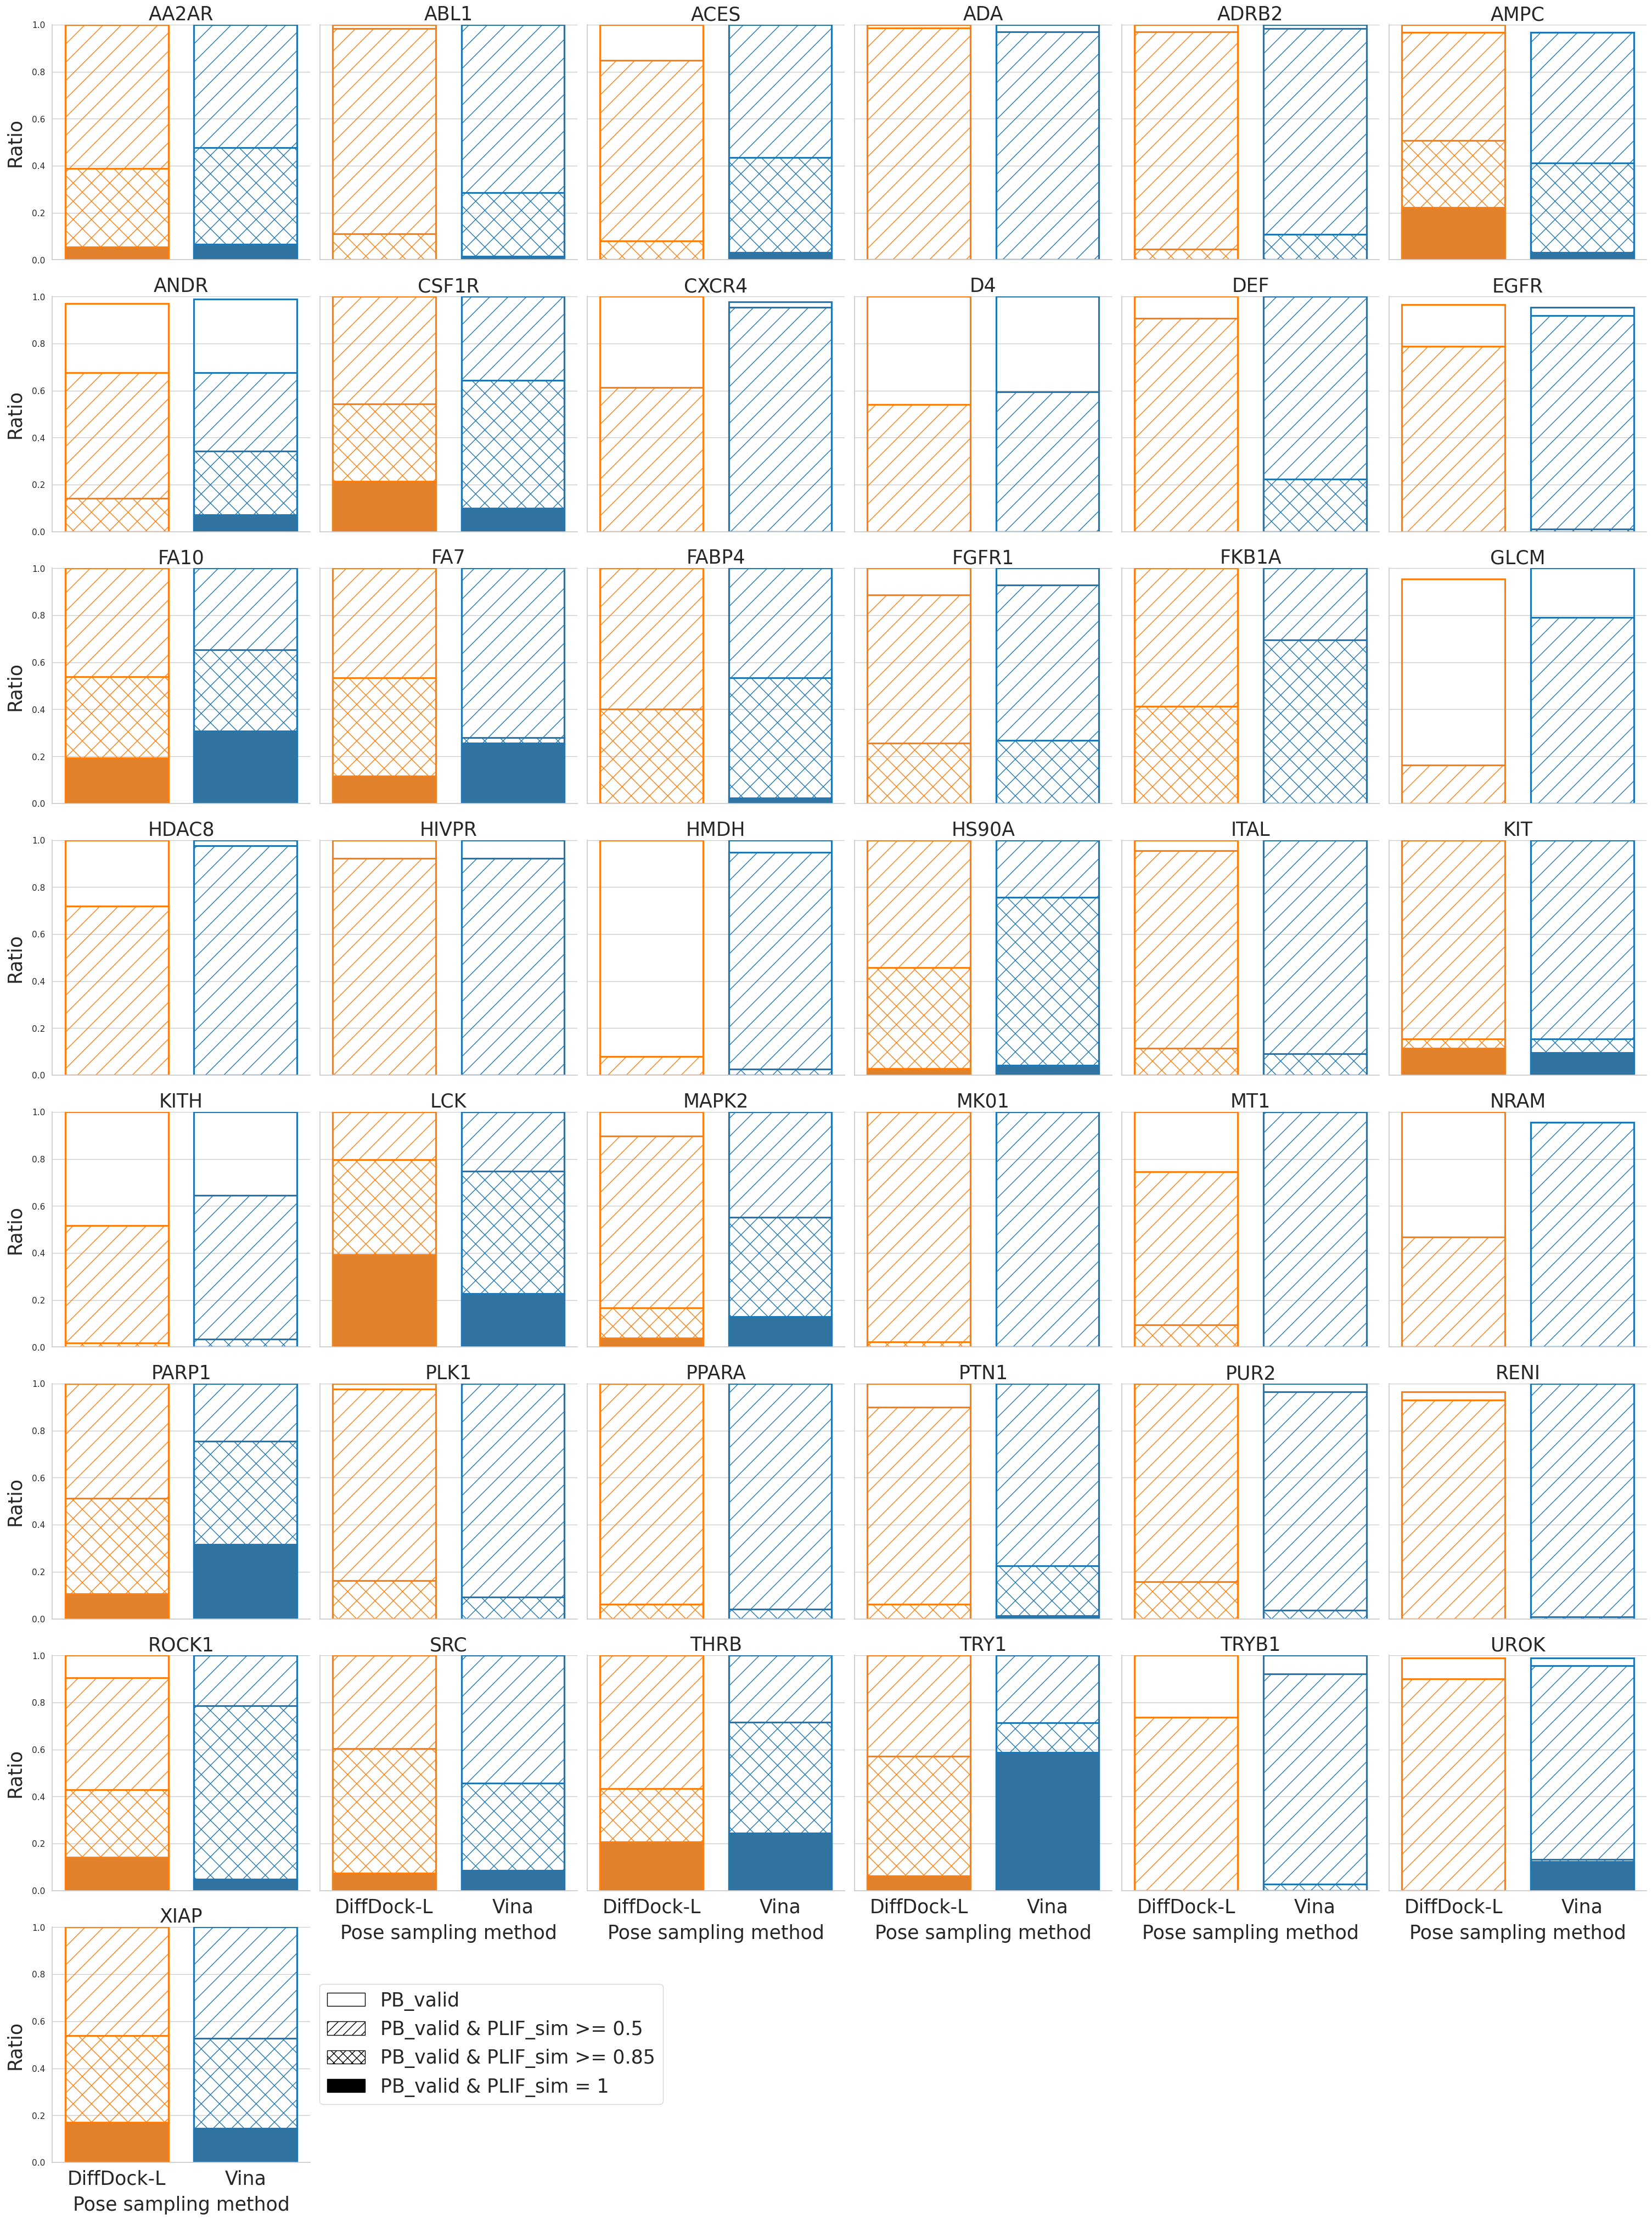

In [19]:
# Figure S4B: multi-plot for all targets
# preprocess sim_all for plotting pb_valid and plif_sim
ratios = [0.5, 0.85, 1]

targets = sim_all_clean["target"].unique()
assert len(targets) == 43, "Check targets."

plot_order = ["DiffDock-L", "Vina"]

stat_all = list()
for target in tqdm(targets):
    sim = sim_all_clean[sim_all_clean["target"] == target]
    for docking in ["DiffDock-L", "Vina"]:
        stat_target = list()
        plif_sim_actives = sim[sim["docking"] == docking]
        total_mol = plif_sim_actives["mol_id"].nunique()
        plif_pb_valid = plif_sim_actives.dropna(subset=["pb_valid"])
        plif_pb_valid = plif_pb_valid[plif_pb_valid["pb_valid"] == True]        
        plif_pb_valid_mol = plif_pb_valid["mol_id"].unique()
        plif_pb_valid_ratio = len(plif_pb_valid_mol) / total_mol
        stat_target.extend([target, docking, total_mol, plif_pb_valid_ratio])
        for r in ratios:
            plif_pb_valid_r = plif_pb_valid[plif_pb_valid["plif_sim"] >= r]
            plif_pb_valid_r_mol = plif_pb_valid_r["mol_id"].unique()
            plif_pb_valid_r_ratio = len(plif_pb_valid_r_mol) / total_mol
            stat_target.extend([plif_pb_valid_r_ratio])
        stat_all.append(stat_target)

ratio_labels = list()
for r in ratios:
    if r == 1:
        ratio_labels.append(f"PB_valid & PLIF_sim = {r}")
    else:
        ratio_labels.append(f"PB_valid & PLIF_sim >= {r}")

columns = ["target", "docking", "total_mol", "PB_valid"] + ratio_labels
stat_all_df = pd.DataFrame(stat_all, columns=columns)

g = sns.FacetGrid(stat_all_df.sort_values(by="target"), col="target", hue="docking", hue_order=plot_order , col_wrap=6, height=5, aspect=1, palette=["tab:orange", "tab:blue"])
ratios = ["PB_valid", 'PB_valid & PLIF_sim >= 0.5', 'PB_valid & PLIF_sim >= 0.85', 'PB_valid & PLIF_sim = 1']
hatches = ["", "/", "\\", None]
for i, r in enumerate(ratios):
    if i == len(ratios)-1:
        g.map(sns.barplot, "docking", r, order=plot_order)
    g.map(sns.barplot, "docking", r, order=plot_order , hatch=hatches[i], fill=False)

g.set_axis_labels("Pose sampling method", "Ratio", fontsize=25, labelpad=10)
g.set_titles(col_template="{col_name}", size=25)
# set size for xticklabels
g.set_xticklabels(plot_order, ha="center", fontsize=25)

g.set(ylim=(0, 1))

handles_ = list()
labels_ = list()
from matplotlib.patches import Patch
handles_.append(Patch(facecolor='white', edgecolor='black'))
handles_.append(Patch(facecolor='white', edgecolor='black', hatch=f"//"))
handles_.append(Patch(facecolor='white', edgecolor='black', hatch="xx"))
handles_.append(Patch(color='black'))
labels = ratios
plt.legend(handles_, labels, loc="upper left", bbox_to_anchor=(1, 0.8), title_fontsize=25, fontsize=25)
plt.savefig(os.path.join(outdir, "FigS4B_multi_PBvalid_PLIFsim.png"), dpi=300, bbox_inches="tight")
plt.show()

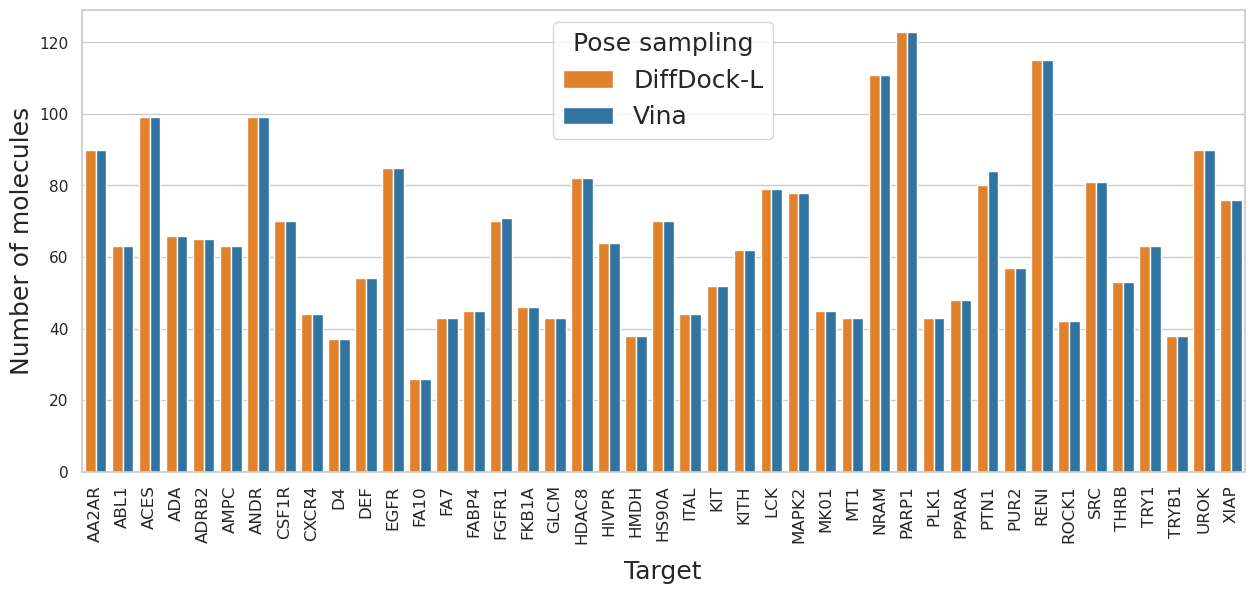

In [41]:
# Figure S1:
# Count the number of DUDE-Z original and docked molecules for each target

stat_all_df = pd.DataFrame(stat_all, columns=["target", "docking", "total_mol", "pb_valid_ratio", 
                                              "pb_valid_50_ratio", "pb_valid_85_ratio", "pb_valid_100_ratio"])
fig, ax = plt.subplots()
sns.barplot(data=stat_all_df.sort_values(by="target"), x="target", y="total_mol", hue="docking", palette=["tab:orange", "tab:blue"])
plt.xlabel("Target", fontsize=18, labelpad=12)
plt.ylabel("Number of molecules", fontsize=18)
plt.legend(fontsize=18, title="Pose sampling", title_fontsize=18) 
plt.xticks(rotation=90)
fig.set_size_inches(15, 6)
plt.xticks(fontsize=12)
plt.savefig(os.path.join(outdir, "FigS1_processed_mol.png"), dpi=300, bbox_inches="tight")
plt.show()

#### PLIF_sim vs. Morgan_sim (Figure 6, S8)

In [7]:
# Preprocessing
# Input: sim_all_clean
targets = sim_all_clean["target"].unique()

sim_plot = pd.DataFrame()
for target in tqdm(targets):
    sim = sim_all_clean.loc[sim_all_clean["target"] == target,:].copy()  
    for docking in ["DiffDock-L", "Vina"]:
        plif_sim_actives = sim.loc[sim["docking"] == docking,:].copy()
        plif_max_plif = plif_sim_actives.groupby(["mol_id", "morgan_sim", "target"]).apply(lambda x: x.loc[x[f"plif_sim"].idxmax()]).reset_index(drop=True)
        plif_max_plif["target"] = target
        sim_plot = pd.concat([sim_plot, plif_max_plif])

sim_plot = sim_plot[sim_plot["pb_valid"] == True]
sim_plot["morgan_sim_bin"] = pd.cut(sim_plot["morgan_sim"], bins=[-0.001, 0.30, 0.75, 1.0], labels=["0-0.30", "0.30-0.75", "0.75-1.0"])
categories_to_plot = ["0-0.30", "0.75-1.0"]
morgan_bins = categories_to_plot

100%|██████████| 43/43 [00:40<00:00,  1.06it/s]


[DiffDock-L] Comparing PLIF similarity between 0.75-1.0 and 0-0.30:
0-0.30: median = 0.5454545454545454
0.75-1.0: median = 0.6666666666666666
Welsch's t = 8.002847403934416, p = 1.917016918829981e-13
Effect size: Cohen's d = 0.6770449356236282


[Vina] Comparing PLIF similarity between 0.75-1.0 and 0-0.30:
0-0.30: median = 0.5714285714285714
0.75-1.0: median = 0.6666666666666666
Welsch's t = 10.45807886491087, p = 2.6434157975105032e-20
Effect size: Cohen's d = 0.6821536794993415


DiffDock-L vs. Vina Comparing PLIF similarity in 0-0.30:
DiffDock-L: n = 66072, Vina: n = 75800
Welsch's t = -36.80094073314287, p = 4.912914219033594e-295
Effect size: Cohen's d = -0.1963953912201841

DiffDock-L vs. Vina Comparing PLIF similarity in 0.75-1.0:
DiffDock-L: n = 168, Vina: n = 180
Welsch's t = -1.6247941799231675, p = 0.10521397335696939
Effect size: Cohen's d = -0.17586797491610595



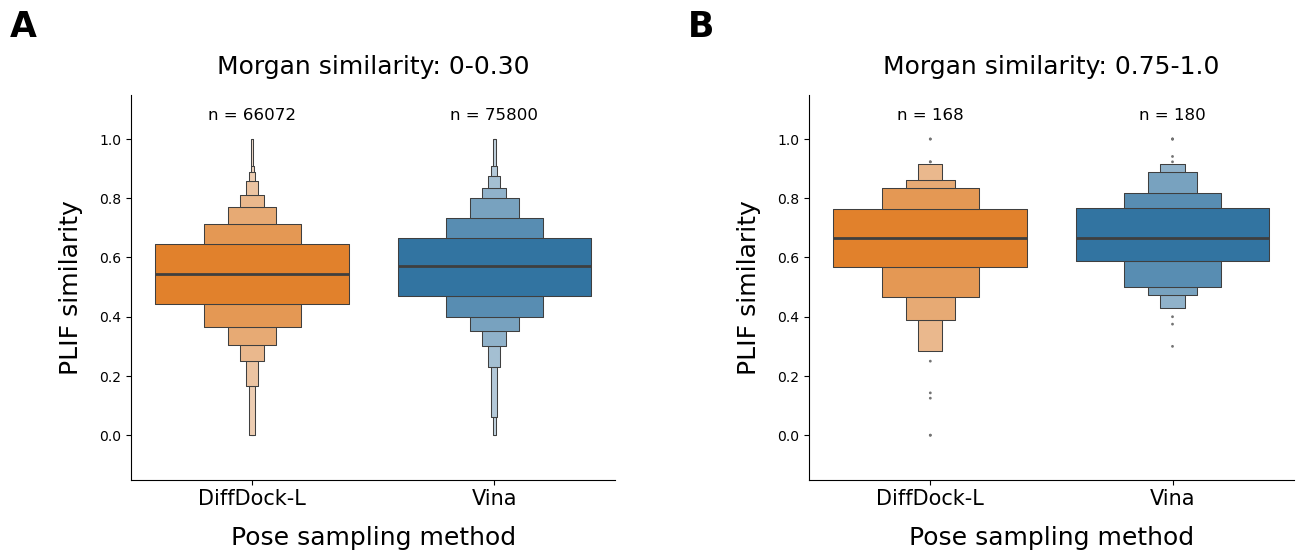

In [9]:
# Figure 6
from numpy import mean
from numpy import var
from math import sqrt
from scipy.stats import ttest_ind

def cohend(d1, d2):
	n1, n2 = len(d1), len(d2)
	s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
	s = sqrt((n1* s1 + n2*s2) / (n1 + n2))
	u1, u2 = mean(d1), mean(d2)
	return (u1 - u2) / s

plot_order = ["DiffDock-L", "Vina"]

for i, bin1 in enumerate(morgan_bins):
    for j, bin2 in enumerate(morgan_bins):
        if i >= j:
            continue
        
        for docking in plot_order:
            print(f"[{docking}] Comparing PLIF similarity between {bin2} and {bin1}:")
            data_bin1 = sim_plot[(sim_plot["docking"] == docking) & (sim_plot["morgan_sim_bin"] == bin1)]["plif_sim"]
            data_bin2 = sim_plot[(sim_plot["docking"] == docking) & (sim_plot["morgan_sim_bin"] == bin2)]["plif_sim"]
            print(f"{bin1}: median = {data_bin1.median()}")
            print(f"{bin2}: median = {data_bin2.median()}")
            t, p1 = ttest_ind(data_bin2, data_bin1, equal_var=False)
            cohen = cohend(data_bin2, data_bin1)
            print(f"Welsch's t = {t}, p = {p1}")
            print(f"Effect size: Cohen's d = {cohen}")
            print("\n")

for bin1 in morgan_bins:
    print(f"{plot_order[0]} vs. {plot_order[1]} Comparing PLIF similarity in {bin1}:")
    ddl_bin = sim_plot[(sim_plot["docking"] == "DiffDock-L") & (sim_plot["morgan_sim_bin"] == bin1)]["plif_sim"]
    vina_bin = sim_plot[(sim_plot["docking"] == "Vina") & (sim_plot["morgan_sim_bin"] == bin1)]["plif_sim"]
    print(f"DiffDock-L: n = {ddl_bin.shape[0]}, Vina: n = {vina_bin.shape[0]}")
    t, p = ttest_ind(ddl_bin, vina_bin, equal_var=False)
    print(f"Welsch's t = {t}, p = {p}")
    intra_bin_cohen = cohend(ddl_bin, vina_bin)
    print(f"Effect size: Cohen's d = {intra_bin_cohen}\n")


fig, axes = plt.subplots(1, 2, sharey=False)
plt.subplots_adjust(wspace=0.4)

sim_plot_partial = sim_plot[sim_plot["morgan_sim_bin"].isin(categories_to_plot)].reset_index()

for i, bin1 in enumerate(categories_to_plot):
    data_bin = sim_plot_partial[sim_plot_partial["morgan_sim_bin"] == bin1]
    sns.boxenplot(data=data_bin, x="docking", y="plif_sim", flier_kws={'s': 1}, line_kws={'linewidth': 2}, ax=axes[i], order=plot_order, hue="docking", hue_order=plot_order, palette=["tab:orange", "tab:blue"])
    sns.despine(ax=axes[i])
    axes[i].set_title(f"Morgan similarity: {bin1}", fontsize=18, pad=15)
    axes[i].set_ylim(-0.15, 1.15)
    axes[i].set_xlabel("Pose sampling method", fontsize=18, labelpad=12)
    axes[i].set_ylabel("PLIF similarity", fontsize=18, labelpad=12)
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].text(-0.25, 1.15, list(("A", "B"))[i], transform=axes[i].transAxes, fontsize=25, fontweight='bold')

    for j, docking in enumerate(plot_order):
        n = sim_plot_partial[(sim_plot_partial["docking"] == docking) & (sim_plot_partial["morgan_sim_bin"] == bin1)].shape[0]
        axes[i].text(j, 1.08, f"n = {n}", ha="center", va="center", fontsize=12)

fig.set_size_inches(15, 5)
plt.savefig(os.path.join(outdir, "Fig6_PLIFsim_Morgansim.png"), dpi=300, bbox_inches="tight")
plt.show()

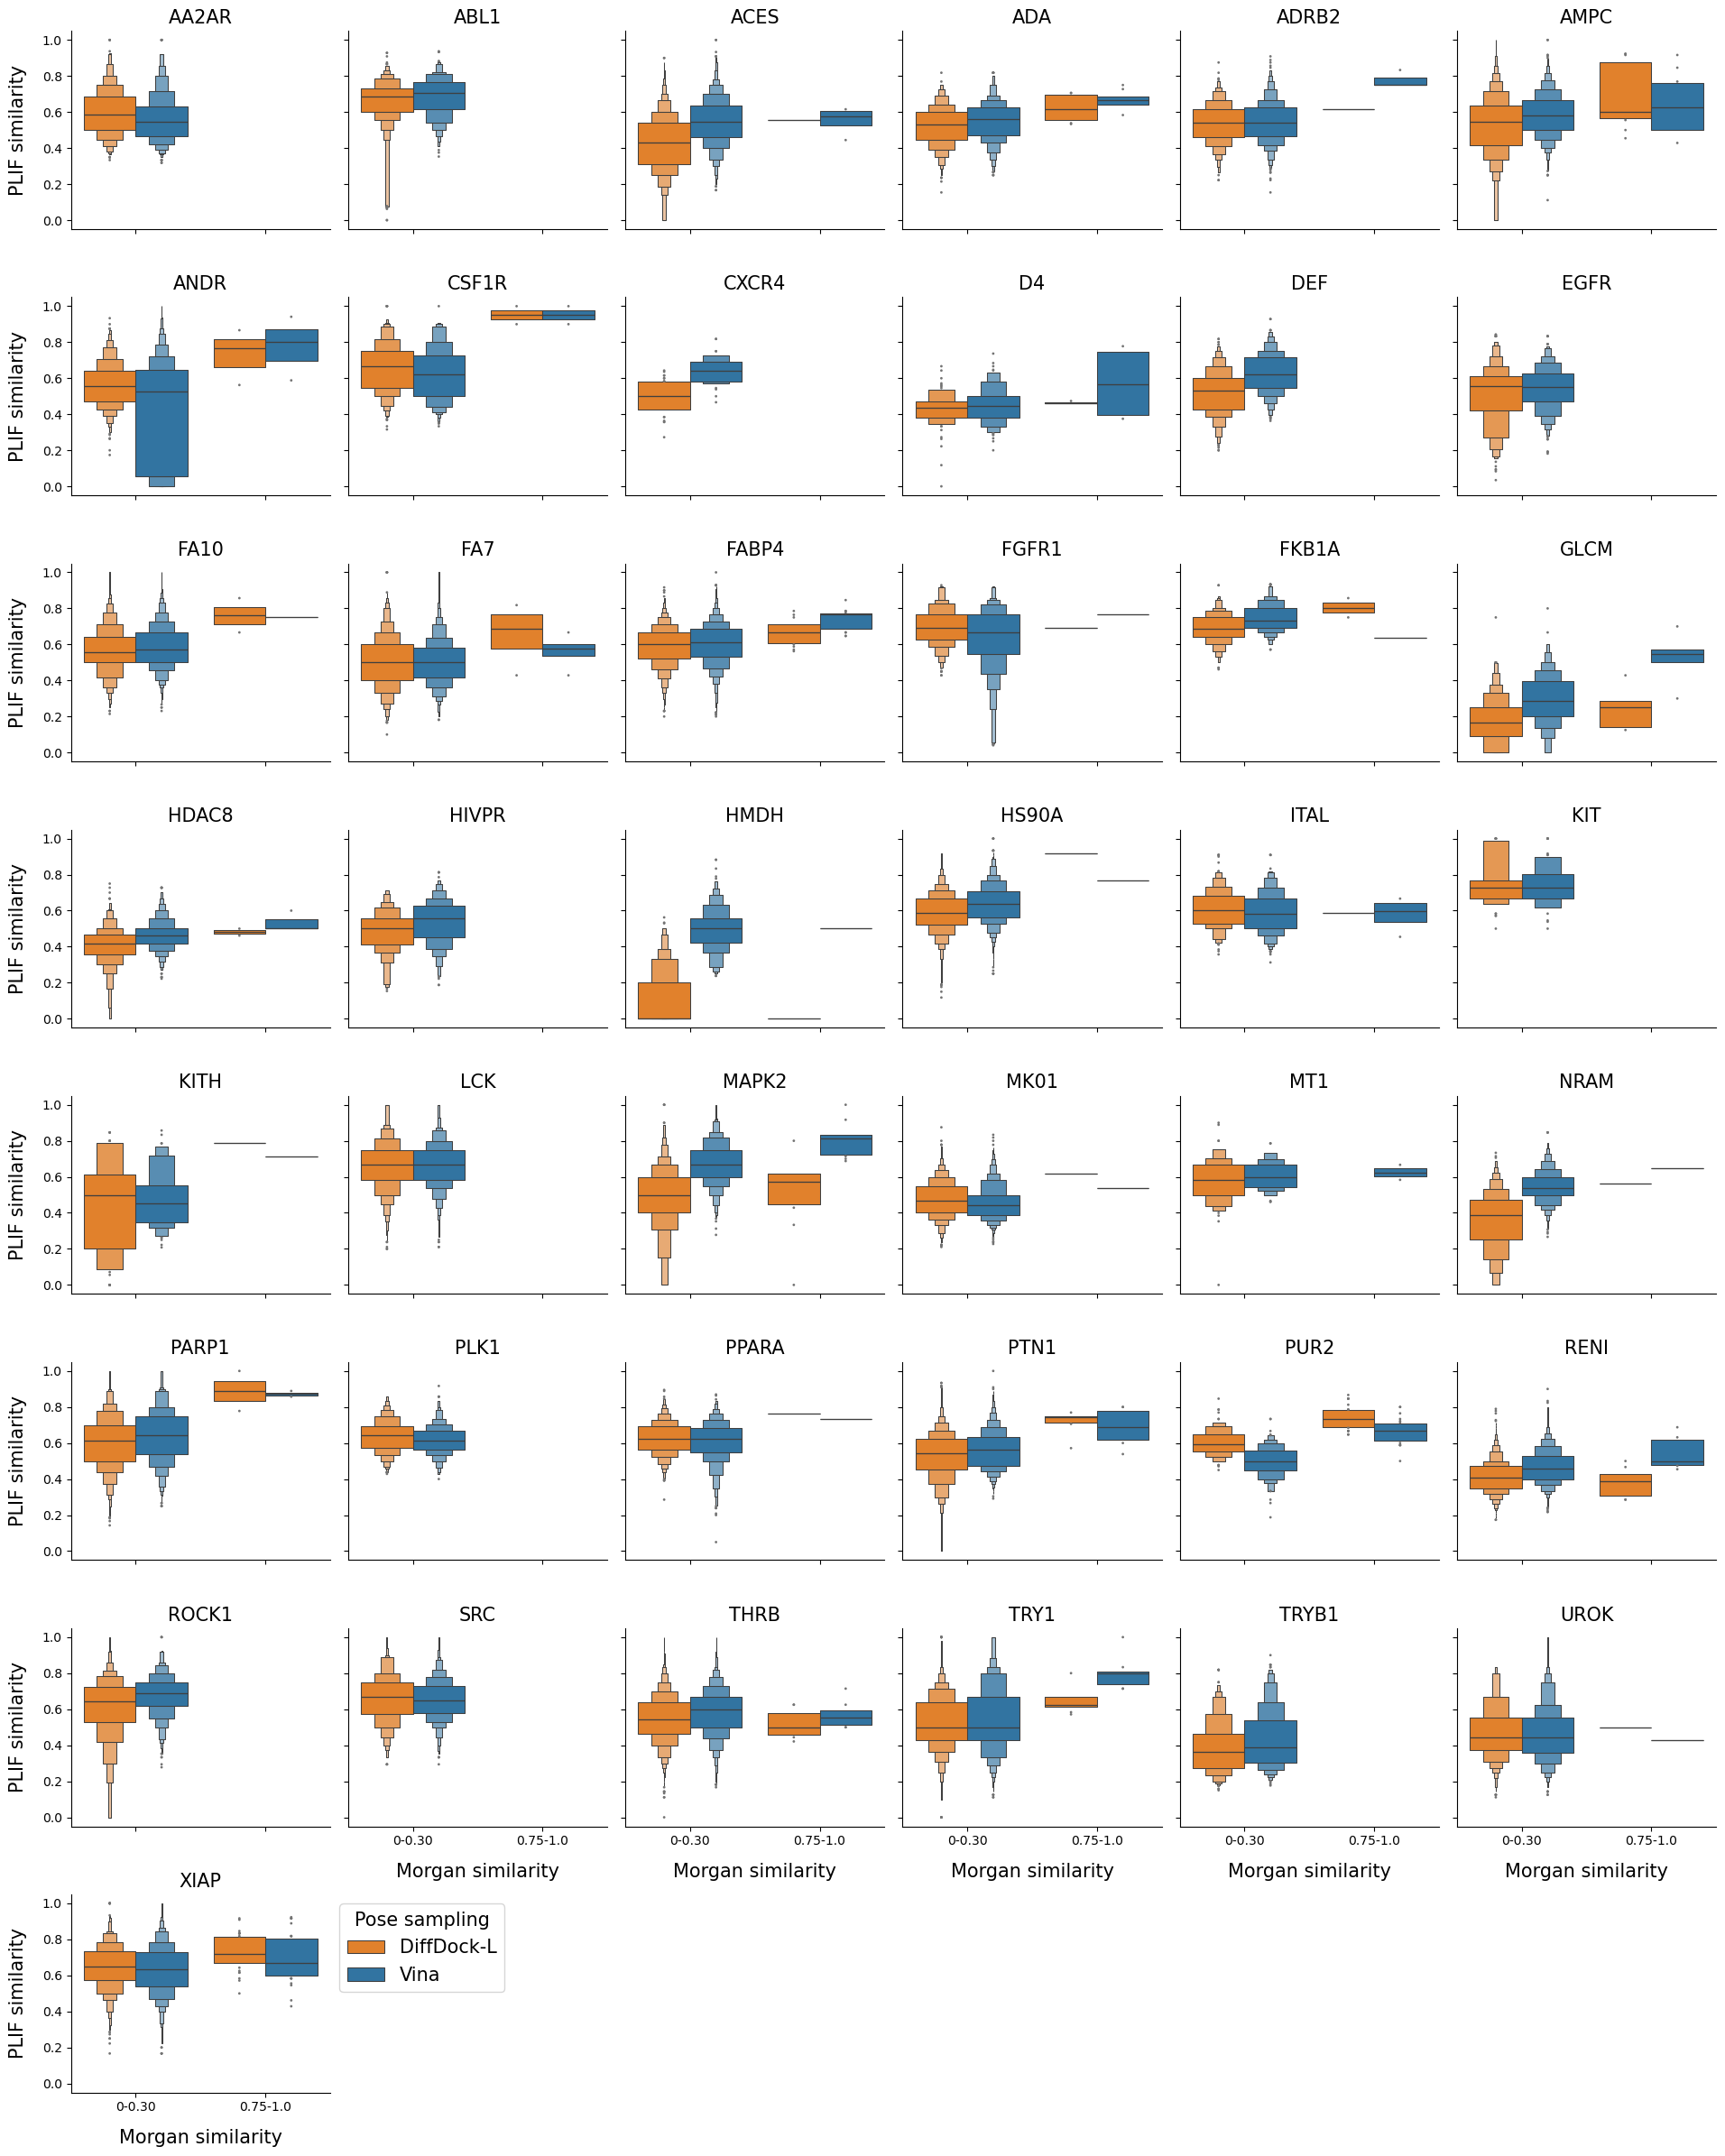

In [16]:
# Figure S8

plot_order = ["DiffDock-L", "Vina"]

sim_plot = sim_plot[sim_plot["morgan_sim_bin"].isin(categories_to_plot)].reset_index()

g = sns.catplot(sim_plot.sort_values(by="target"), x=f"morgan_sim_bin", y="plif_sim", col="target", hue="docking", kind="boxen", hue_order=plot_order, 
                col_wrap=6, height=3, aspect=1, palette=["tab:orange", "tab:blue"], order=categories_to_plot, dodge=True, flier_kws={'s': 1})
                
g._legend.remove()
g.set_axis_labels("Morgan similarity", "PLIF similarity", fontsize=15, labelpad=12)
g.set_titles(col_template="{col_name}", size=15)
plt.tight_layout()
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Pose sampling", title_fontsize=15, fontsize=15)
plt.savefig(os.path.join(outdir, "FigS8_PLIFsim_Morgansim.png"), dpi=300, bbox_inches="tight")
plt.show()